### Analyzing historical demand and predicting sales using Prophet and ARIMA

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import collections
import csv
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
%matplotlib inline

In [2]:
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation

In [3]:
weekly_sales_df = pd.read_csv('train.csv', header=0, parse_dates=['Date'])

In [4]:
weekly_sales_df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [5]:
weekly_sales_df.tail()

,Store,Dept,Date,Weekly_Sales,IsHoliday
421565,45,98,2012-09-28,508.37,False
421566,45,98,2012-10-05,628.10,False
421567,45,98,2012-10-12,1061.02,False
421568,45,98,2012-10-19,760.01,False
421569,45,98,2012-10-26,1076.80,False


In [6]:
weekly_sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
Store           421570 non-null int64
Dept            421570 non-null int64
Date            421570 non-null datetime64[ns]
Weekly_Sales    421570 non-null float64
IsHoliday       421570 non-null bool
dtypes: bool(1), datetime64[ns](1), float64(1), int64(2)
memory usage: 13.3 MB


In [7]:
stores_all = weekly_sales_df['Store'].unique()

In [8]:
depts_all = weekly_sales_df['Dept'].unique()

In [9]:
print(stores_all)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45]


In [10]:
print(depts_all)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 16 17 18 19 20 21 22 23 24 25 26
 27 28 29 30 31 32 33 34 35 36 37 38 40 41 42 44 45 46 47 48 49 51 52 54 55
 56 58 59 60 67 71 72 74 77 78 79 80 81 82 83 85 87 90 91 92 93 94 95 96 97
 98 99 39 50 43 65]


### EDA

In [11]:
## define a function to visualize the sales data for stores and depts

def eda_sales(df, store_locations, departments):
    nrow = len(store_locations)
    ncol = len(departments)
    
    fig,ax = plt.subplots(nrow,ncol)
    r = 0
    c = 0
    
    for store in store_locations:
        c = 0
        for dept in departments:
            df_str_dept = df[(df['Store']==store) & (df['Dept']==dept)][['Date', 'Weekly_Sales']]
            df_str_dept = df_str_dept.rename(columns={'Date': 'ds', 'Weekly_Sales': 'y'}) #rename the cols as needed by fbprophet
            df_str_dept.set_index('ds').y.plot(ax=ax[r,c], sharey=True,figsize=(18,18),title='Weekly Sales for Store %d - Dept %d' %(store,dept))        
            c += 1
            plt.tight_layout()
                                               
        r += 1                                 

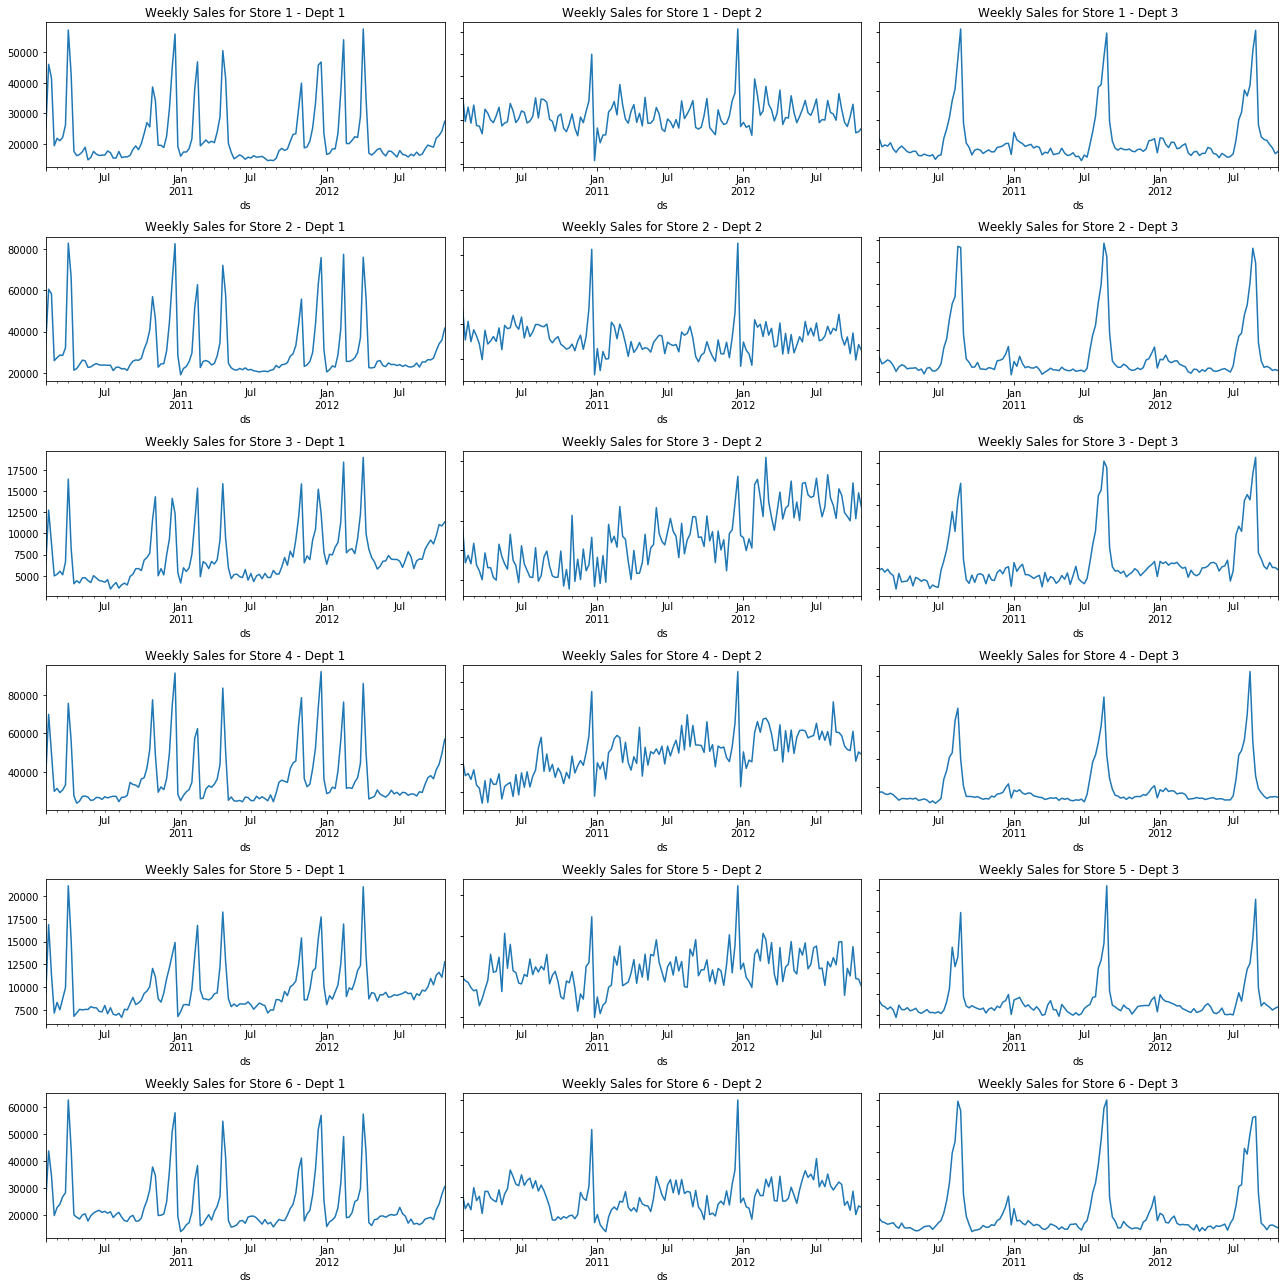

In [12]:
eda_sales(weekly_sales_df,store_locations=[1,2,3,4,5,6],departments=[1,2,3])
#eda_sales(weekly_sales_df,store_locations=stores_all,departments=depts_all)

In [13]:
## Get the holiday dates (from all stores/depts) 
events = weekly_sales_df[(weekly_sales_df['IsHoliday']==True)][['Date']]     

In [14]:
events['Date'].unique()

array(['2010-02-12T00:00:00.000000000', '2010-09-10T00:00:00.000000000',
       '2010-11-26T00:00:00.000000000', '2010-12-31T00:00:00.000000000',
       '2011-02-11T00:00:00.000000000', '2011-09-09T00:00:00.000000000',
       '2011-11-25T00:00:00.000000000', '2011-12-30T00:00:00.000000000',
       '2012-02-10T00:00:00.000000000', '2012-09-07T00:00:00.000000000'], dtype='datetime64[ns]')

### fbProphet

In [15]:
## Create holiday df with lower and upper window = 0, as we do not want to extend the holiday out
# to days around the given date
def create_holidays_df():
    presidentsday_df = pd.DataFrame({
        'holiday': 'PresidentsDay',
        'ds': pd.to_datetime(['2/12/2010','2/11/2011','2/10/2012']),
        'lower_window': 0,
        'upper_window': 0
        })

    laborday_df = pd.DataFrame({
        'holiday': 'LaborDay',
        'ds': pd.to_datetime(['9/10/2010','9/9/2011','9/7/2012']),
        'lower_window': 0,
        'upper_window': 0
        })

    thanksgiving_df = pd.DataFrame({
        'holiday': 'LaborDay',
        'ds': pd.to_datetime(['11/26/2010','11/25/2011']),
        'lower_window': 0,
        'upper_window': 0
        })

    newyears_df = pd.DataFrame({
        'holiday': 'NewYearDay',
        'ds': pd.to_datetime(['12/31/2010','12/30/2011']),
        'lower_window': 0,
        'upper_window': 0
        })
    holidays_df = pd.concat((presidentsday_df, laborday_df, thanksgiving_df, newyears_df))
    return holidays_df

In [16]:
## Define a function to get individual store, dept sales and impute missing dates. Then call the func to perform model.
def forecast_sales_prophet(sales_df, stores, depts):    
    
    results_dict = collections.defaultdict(list) 
    
    # create holidays/promotions events df
    holidays_df = create_holidays_df()              
    
    for store in stores:
        for dept in depts:
            df_str_dept = sales_df[(sales_df['Store']==store) & (sales_df['Dept']==dept)][['Date', 'Weekly_Sales']]            
            df_str_dept = df_str_dept.rename(columns={'Date': 'ds', 'Weekly_Sales': 'y'}) #rename the cols as needed by fbprophet            
            
            ## Find if there are missing dates in the df_str_dept df
               ## Get the date ranges in the df with all stores/depts
            daterange = pd.date_range(start=sales_df['Date'].min().date(),end=sales_df['Date'].max().date(), freq='W-FRI') 
            
               
            df_str_dept.set_index('ds',inplace=True)
            missing = sorted(set(daterange)  - set(df_str_dept.index))            
            
            if(len(missing) >= 1):                
                df_str_dept = df_str_dept.reindex(daterange, fill_value=0) ## fill missing weekdays with 0
                df_str_dept = df_str_dept.rename_axis('ds').reset_index() ## change ds from index to col                
            else:
                df_str_dept = df_str_dept.rename_axis('ds').reset_index() ## change ds from index to col
             
            ##Split df into train and test data as 70/30 of df
            train_size = int(len(df_str_dept) * 0.70)
            train_df, test_df = df_str_dept[0:train_size], df_str_dept[train_size:len(df_str_dept)]  
            
            # Instantiate Prophet and include holiday effects & yearly_seasonality 
            # as our data follows yearly seasonal pattern
            model = Prophet(holidays=holidays_df, yearly_seasonality=True, 
                    weekly_seasonality=False, daily_seasonality=False) 
            model.add_seasonality(name='yearly', period='365.25', fourier_order=7)
            model.fit(train_df)
    
            # Define future timeframe, with len of test_df
            future = model.make_future_dataframe(periods=len(test_df), freq='W-FRI') 
    
            # Use predict method to forecast for the future timeframe
            forecast = model.predict(future)    

            #metrics - create df of predicted data and original data in test_df
            metrics_df = (forecast.set_index('ds')[['yhat']][test_df.index[0]:]).join(test_df.set_index('ds').y).reset_index()
            mse = mean_squared_error(metrics_df.y, metrics_df.yhat)
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(metrics_df.y, metrics_df.yhat)
            
            results_dict[(store, dept)].append(rmse)
            results_dict[(store, dept)].append(mae)
    return results_dict

In [14]:
    # Plot the forecst
    #model.plot(forecast, xlabel='Date', ylabel='Weekly Sales')
    #plt.title('Forecast graph for Store %d - Dept %d'%(store, dept),fontsize=18,color='blue')
    #model.plot_components(forecast);
    
    # Cross Validation
    #df_cv = cross_validation(model, horizon='120 days')
    #mse_cv = mean_squared_error(df_cv.y, df_cv.yhat)
    #rmse_cv = np.sqrt(mse_cv)
    #mae_cv = mean_absolute_error(df_cv.y, df_cv.yhat)

In [17]:
%%time
prophet_results_s123 = forecast_sales_prophet(weekly_sales_df, stores=[1,2,3], depts=depts_all)

Wall time: 6min 30s


In [18]:
prophet_results_s123 ## store, dept -- RMSE, MAE

defaultdict(list,
            {(1, 1): [6221.381253801942, 3781.8415660181904],
             (1, 2): [3029.4524901882382, 2575.5107106139944],
             (1, 3): [4048.0607888288696, 2313.6109292711362],
             (1, 4): [2928.2502589633114, 2287.1662686535824],
             (1, 5): [5504.9124169320521, 4020.5251212521839],
             (1, 6): [2074.8631885257987, 1466.1087739365942],
             (1, 7): [9574.4318891836156, 5999.8880487986307],
             (1, 8): [3982.4862526542065, 3418.7517277228662],
             (1, 9): [5252.5233726807328, 3477.9574693329187],
             (1, 10): [3500.6626912573624, 2896.731736069748],
             (1, 11): [4872.664118495788, 3897.8866192481332],
             (1, 12): [1297.3383468761276, 1078.7451180970513],
             (1, 13): [3978.007549941949, 3266.8744581151532],
             (1, 14): [3109.0358588322156, 2100.5029804953056],
             (1, 16): [5711.01463183128, 4420.0600652622979],
             (1, 17): [1284.649221134

In [19]:
## define a function to slice the resultset into smaller chunks by dept count
from itertools import islice

def chunks(data, SIZE=100):
    it = iter(data)
    for i in range(0, len(data), SIZE):
        yield {k:data[k] for k in islice(it, SIZE)}

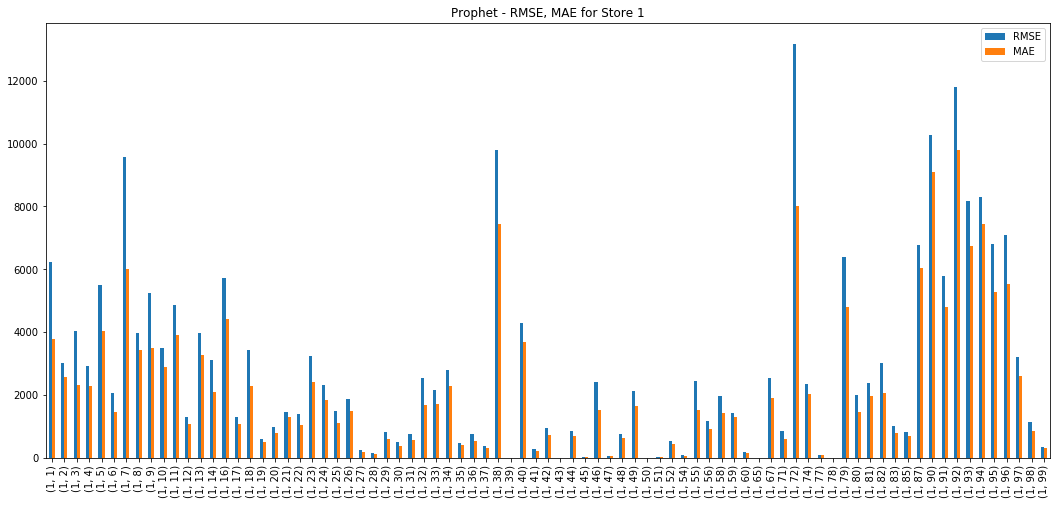

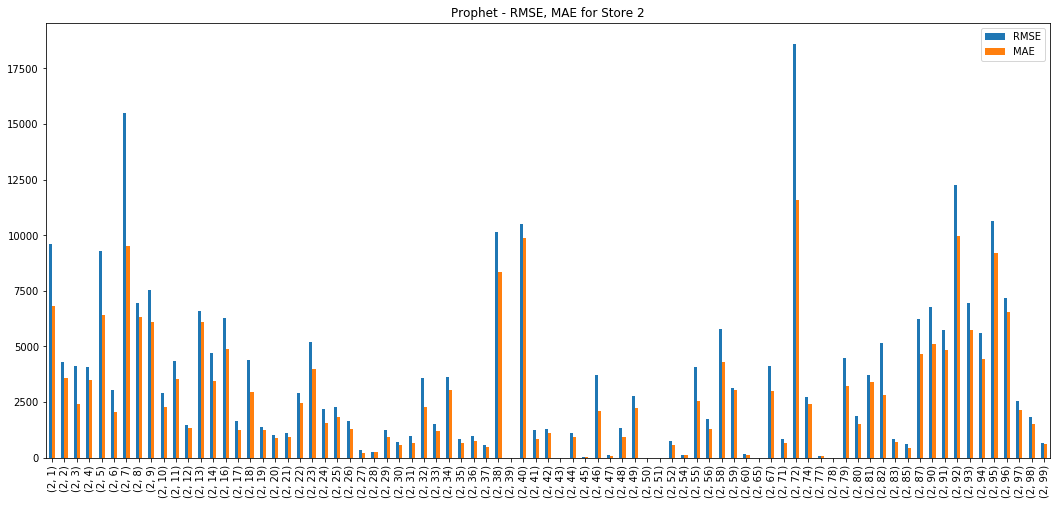

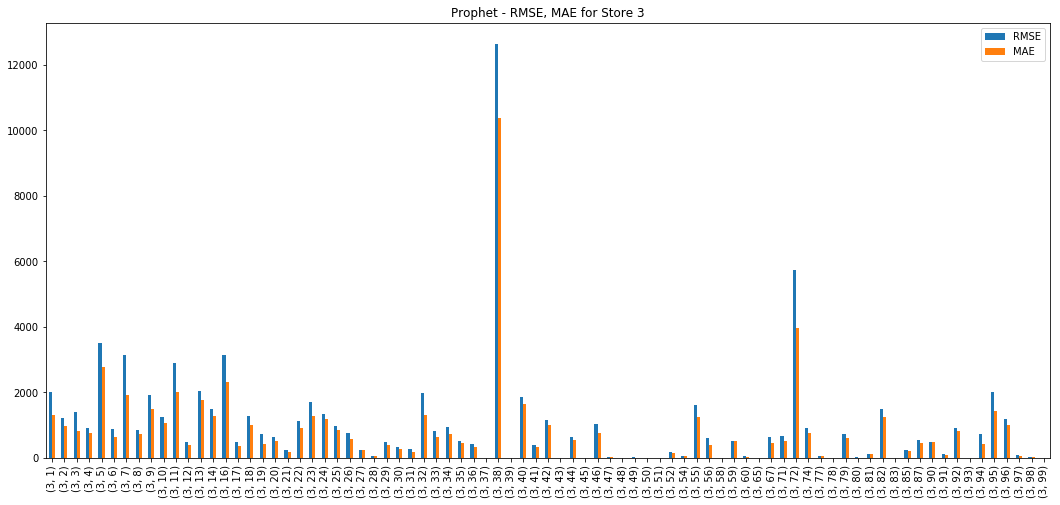

In [20]:
for item in chunks(prophet_results_s123, 81):
    df = pd.DataFrame(item).T
    ax = df.plot(kind='bar',figsize=(18,8),title='Prophet - RMSE, MAE for Store %d' %list(item.keys())[0][0])
    ax.legend(['RMSE', 'MAE']);

#### Execute the forecast sales function for ALL stores and ALL Depts

In [22]:
%%time
fbprophet_forecast_results = forecast_sales_prophet(weekly_sales_df, stores=stores_all, depts=depts_all)

Wall time: 1h 37min 52s


In [23]:
fbprophet_forecast_results

defaultdict(list,
            {(1, 1): [6221.381253801942, 3781.8415660181904],
             (1, 2): [3029.4524901882382, 2575.5107106139944],
             (1, 3): [4048.0607888288696, 2313.6109292711362],
             (1, 4): [2928.2502589633114, 2287.1662686535824],
             (1, 5): [5504.9124169320521, 4020.5251212521839],
             (1, 6): [2074.8631885257987, 1466.1087739365942],
             (1, 7): [9574.4318891836156, 5999.8880487986307],
             (1, 8): [3982.4862526542065, 3418.7517277228662],
             (1, 9): [5252.5233726807328, 3477.9574693329187],
             (1, 10): [3500.6626912573624, 2896.731736069748],
             (1, 11): [4872.664118495788, 3897.8866192481332],
             (1, 12): [1297.3383468761276, 1078.7451180970513],
             (1, 13): [3978.007549941949, 3266.8744581151532],
             (1, 14): [3109.0358588322156, 2100.5029804953056],
             (1, 16): [5711.01463183128, 4420.0600652622979],
             (1, 17): [1284.649221134

### Write results to csv

In [24]:
with open('fbprophet_results.csv', 'w', newline='') as f:
    writer = csv.writer(f) 
    writer.writerow(['Store', 'Dept', 'RMSE', 'MAE'])
    for keys,values in fbprophet_forecast_results.items():        
        writer.writerow(list(keys)+values)

### Plot RMSE, MAE for all depts in a Store

C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


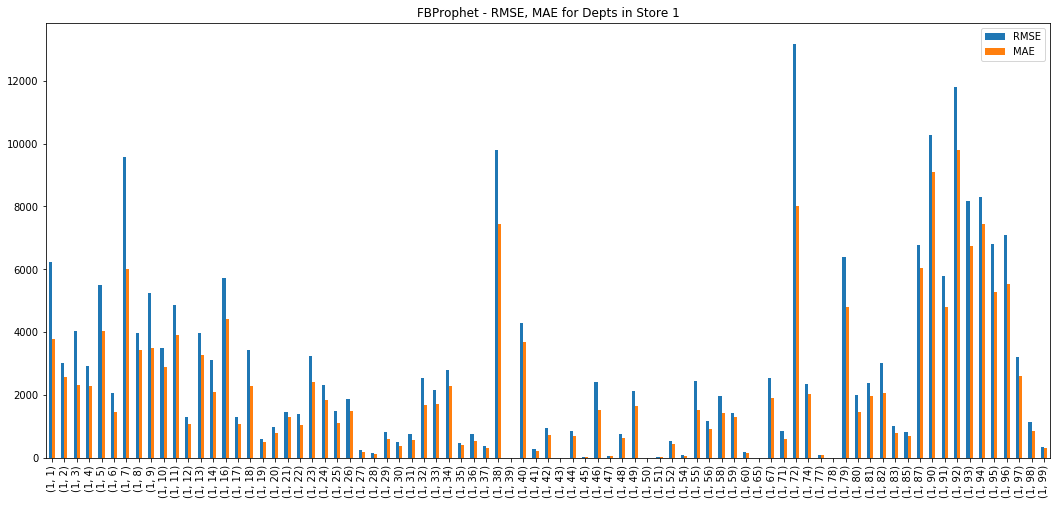

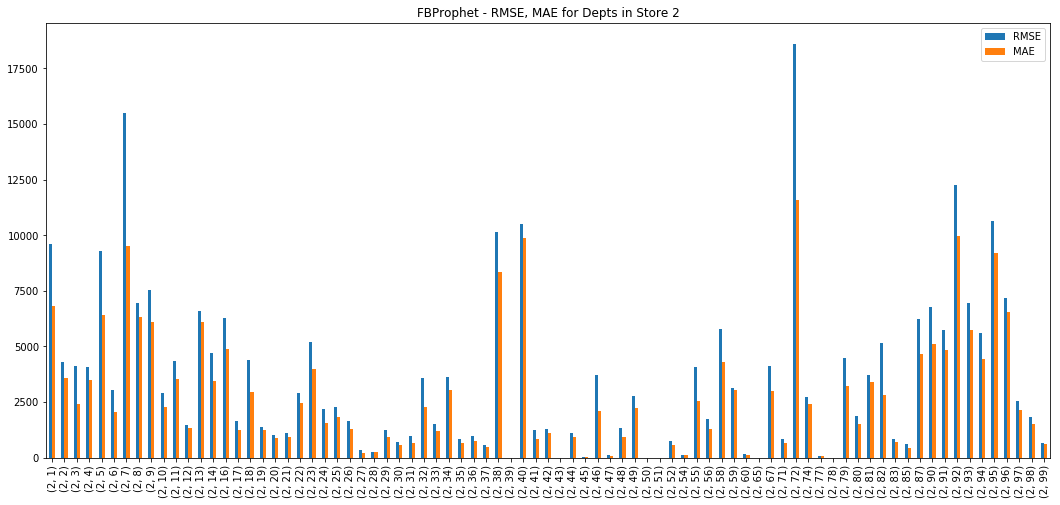

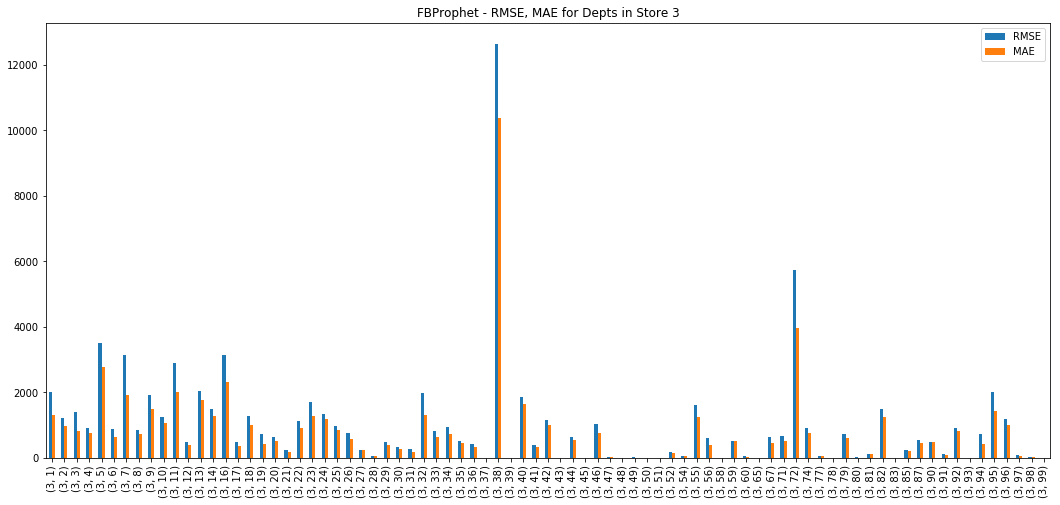

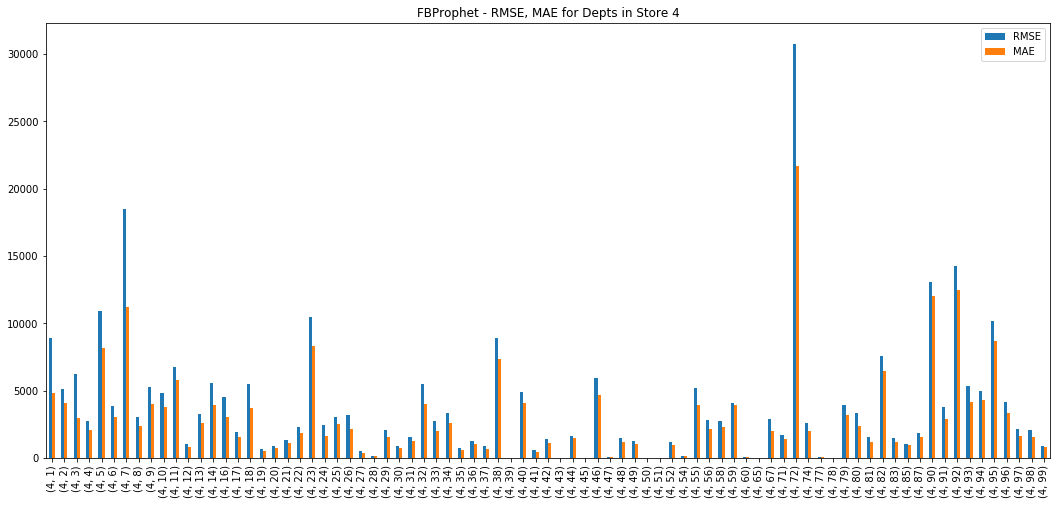

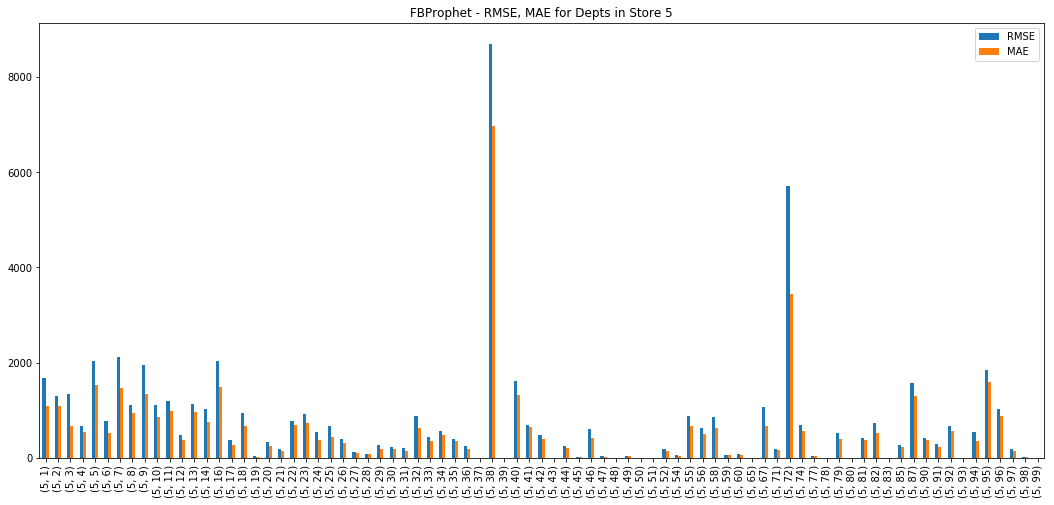

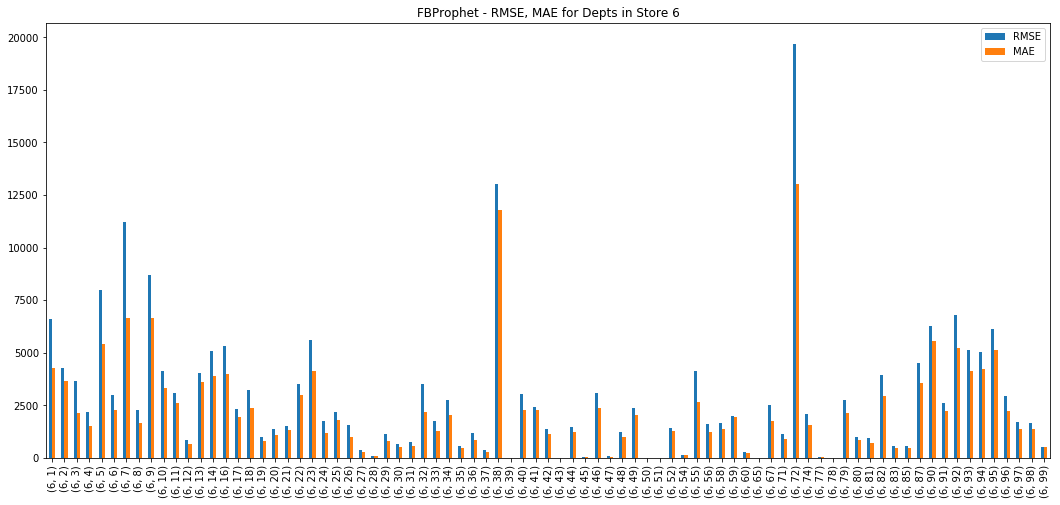

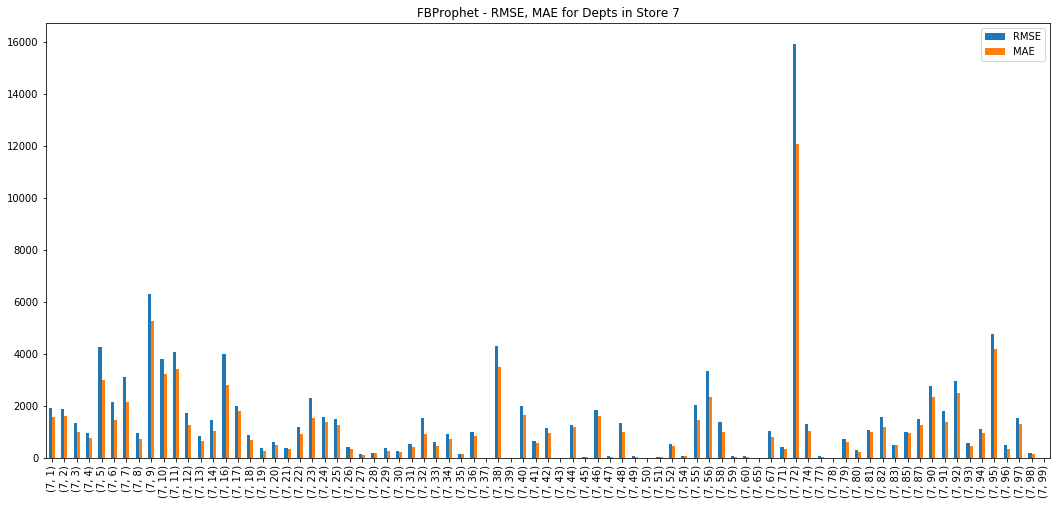

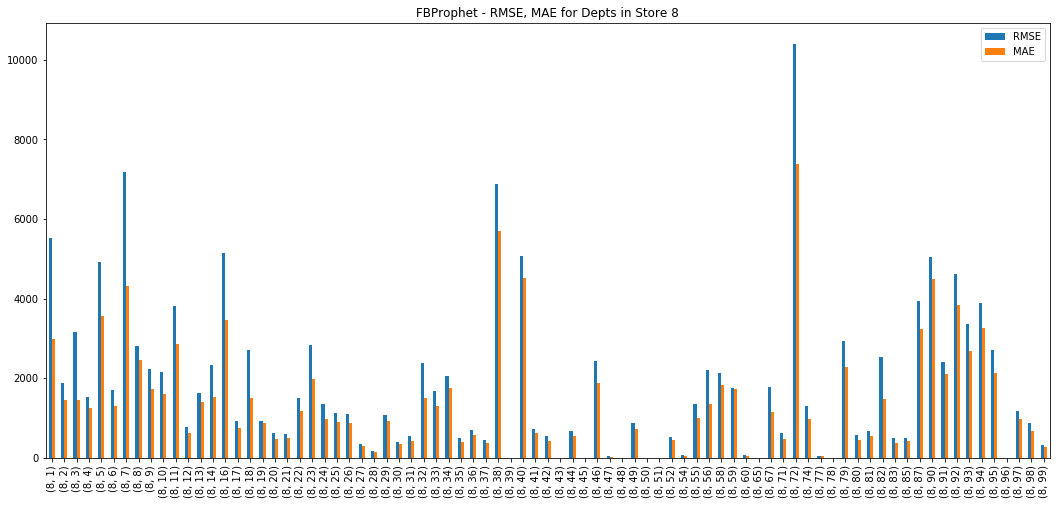

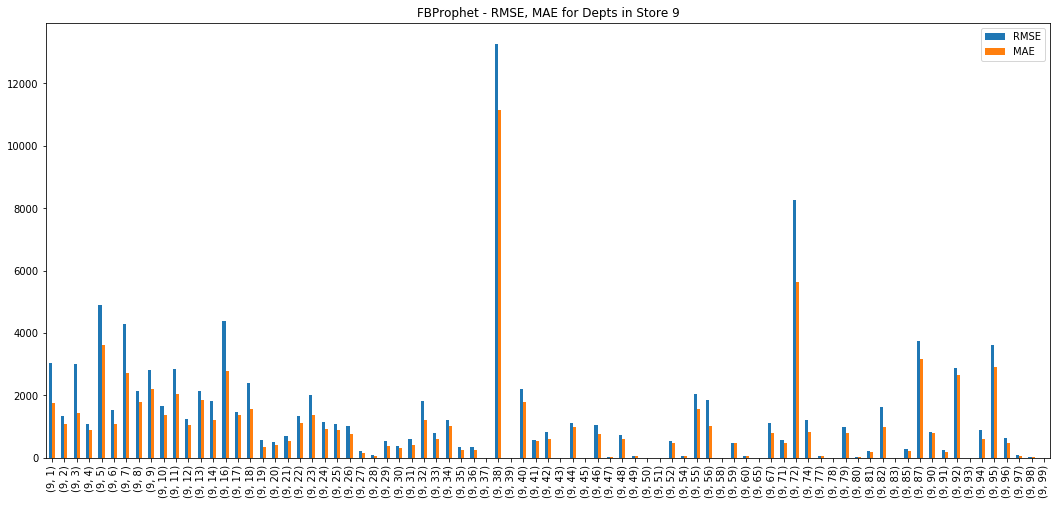

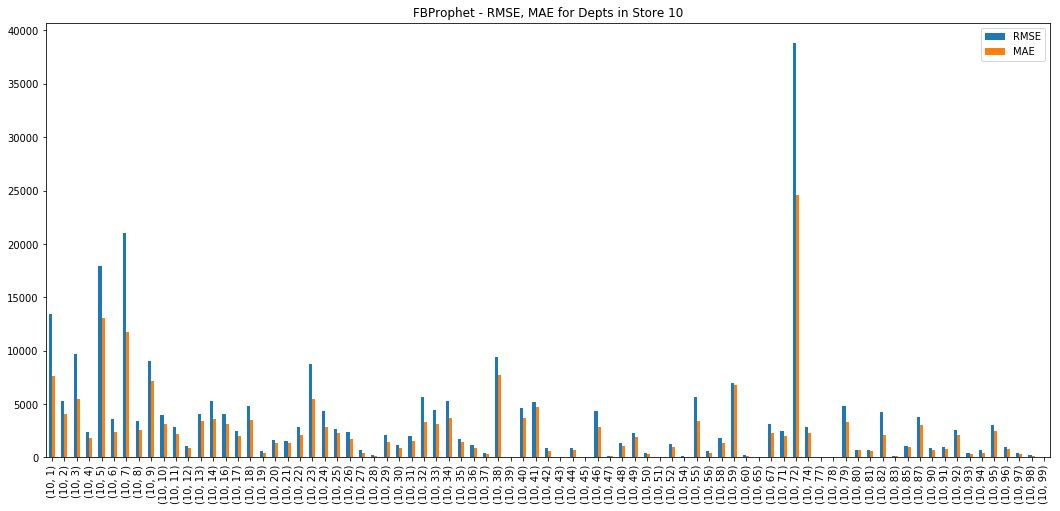

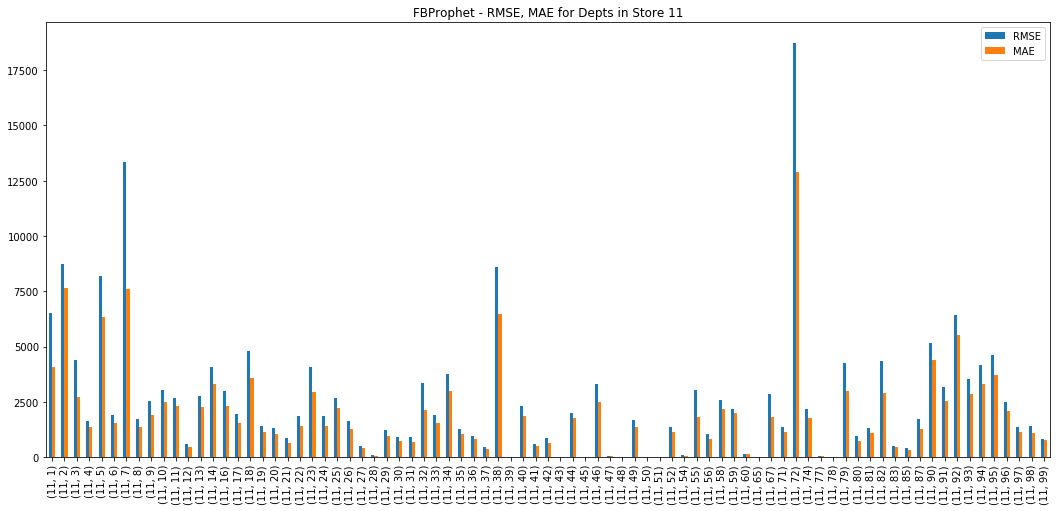

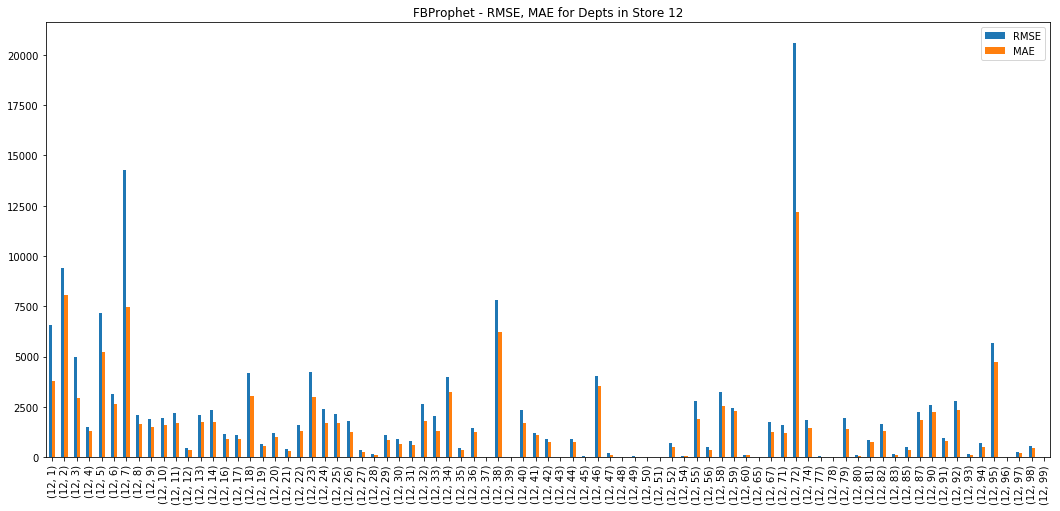

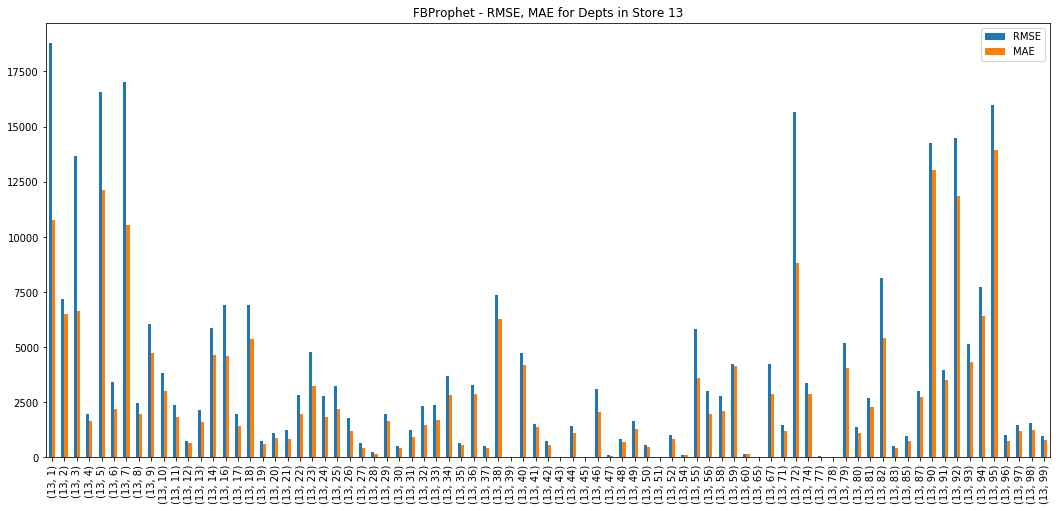

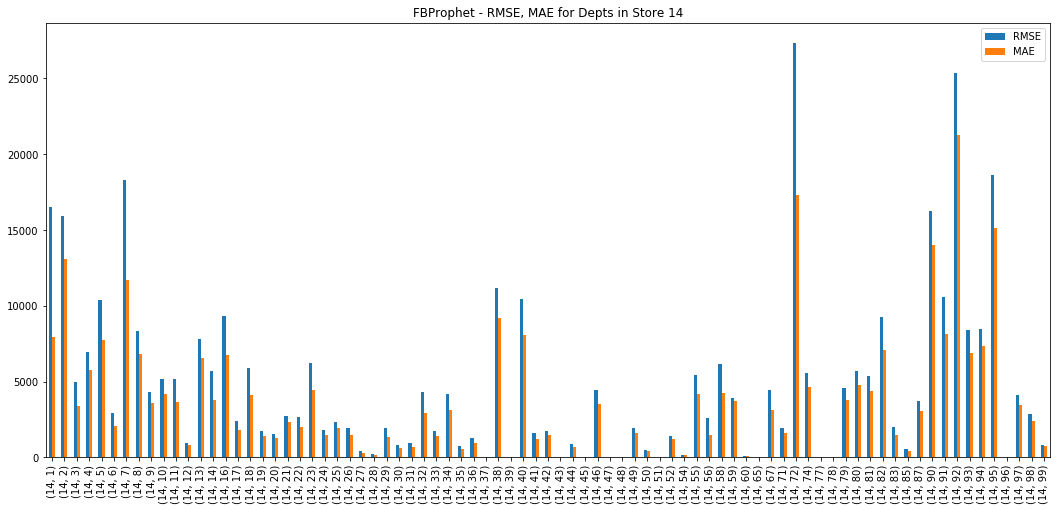

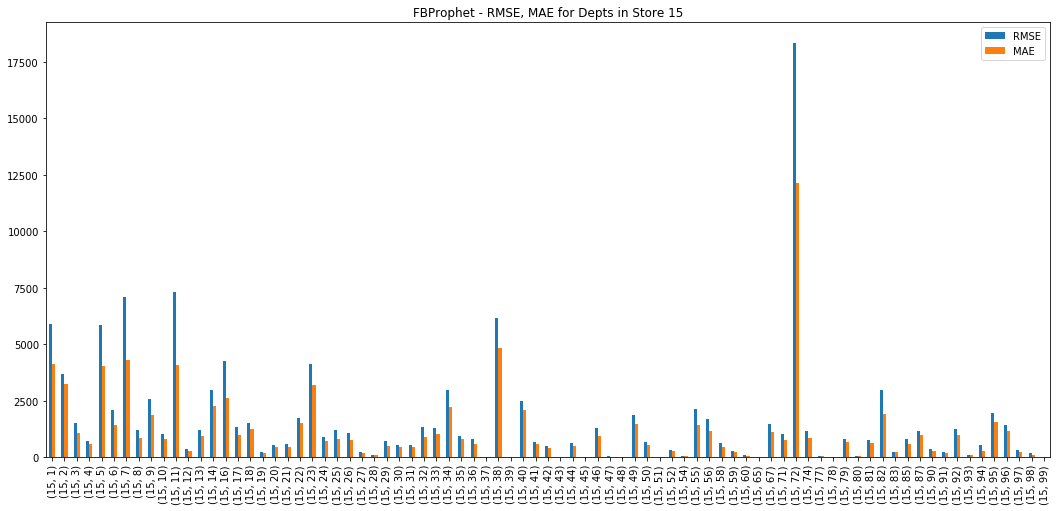

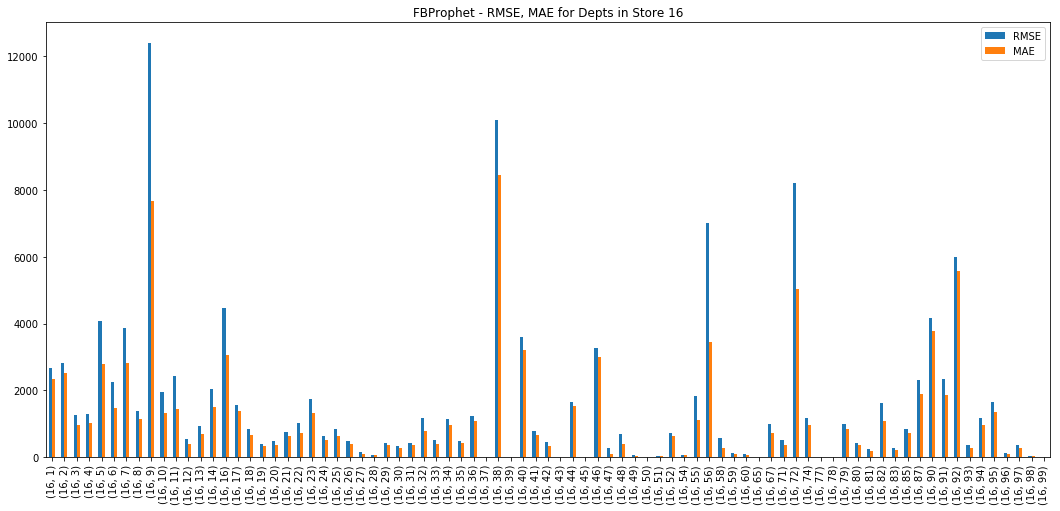

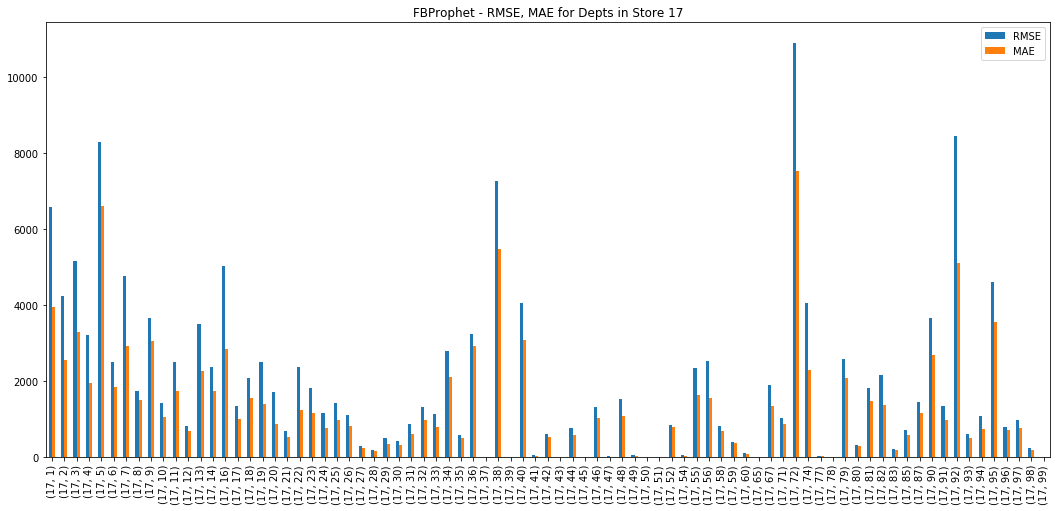

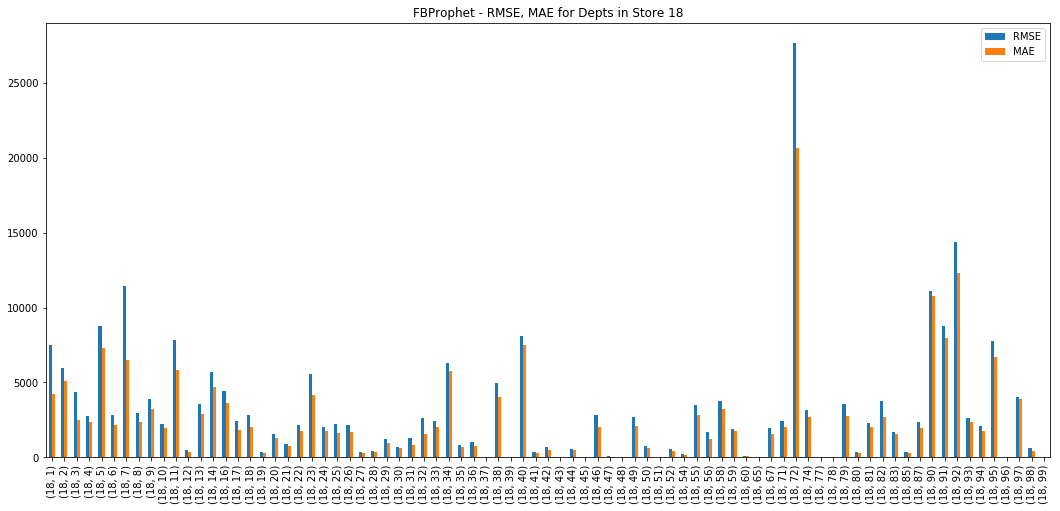

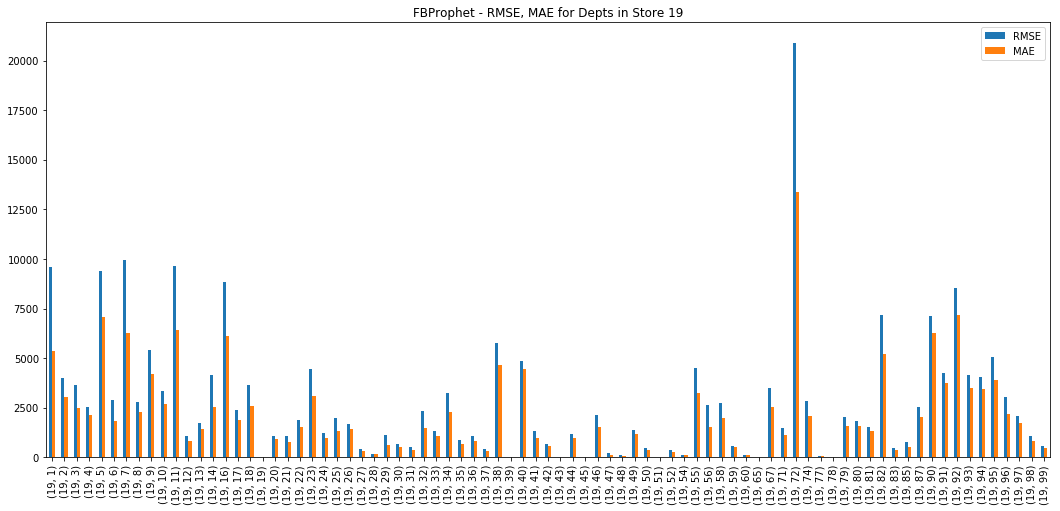

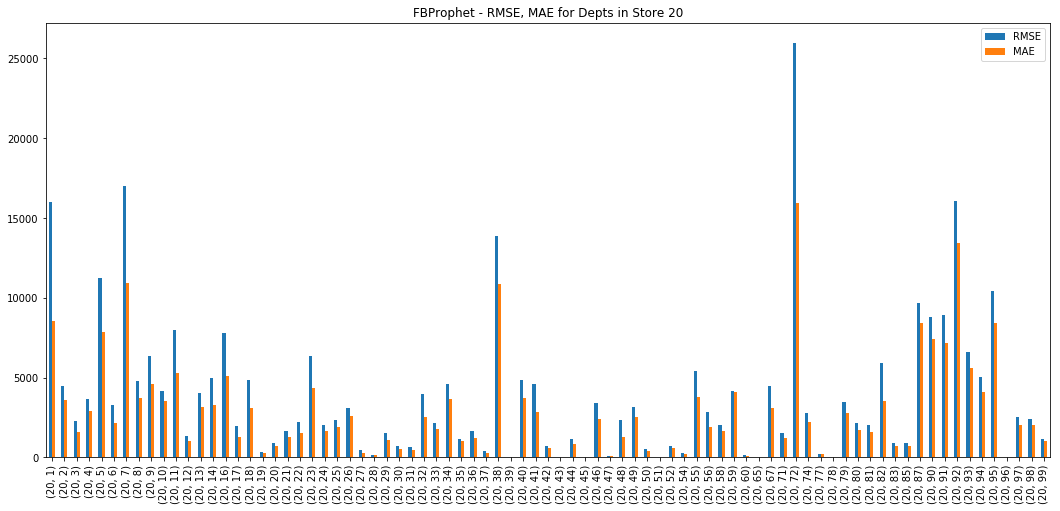

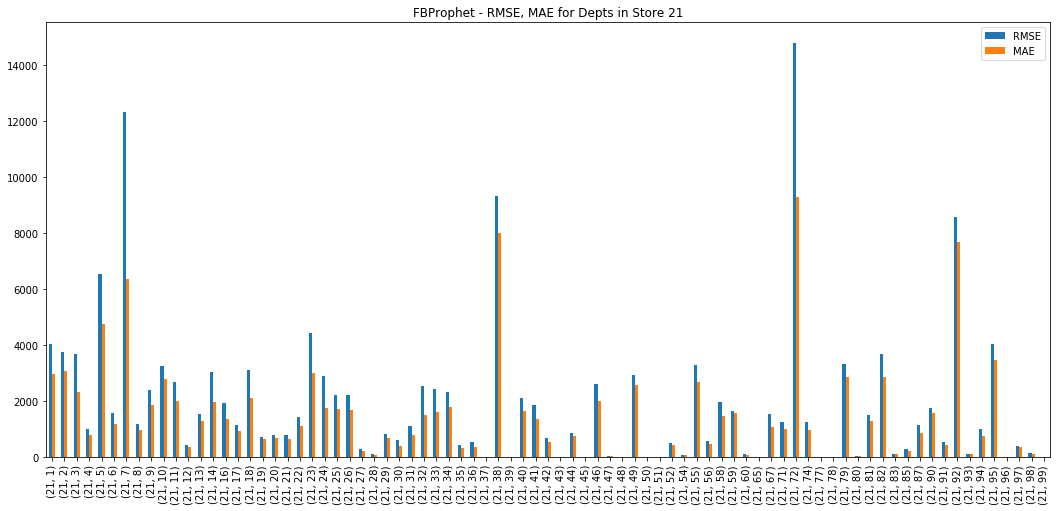

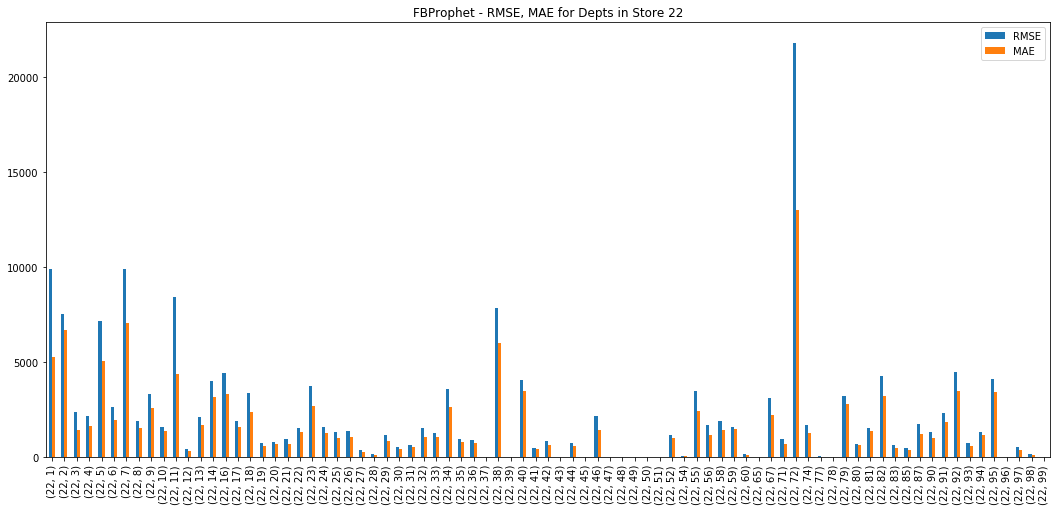

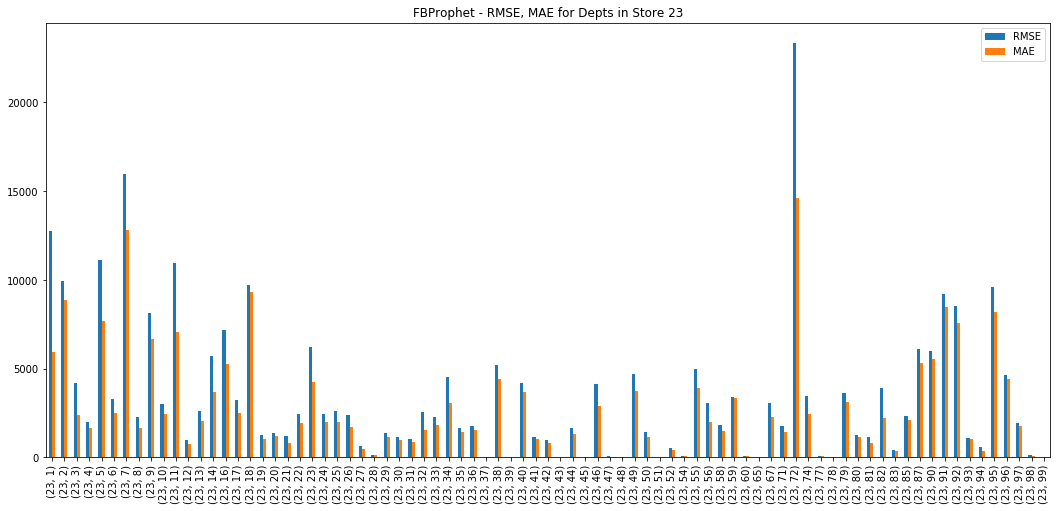

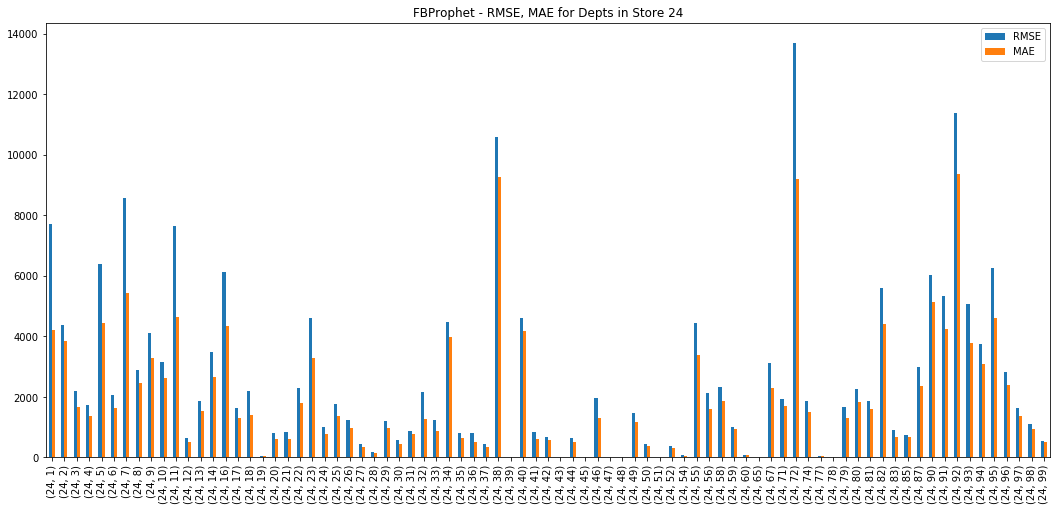

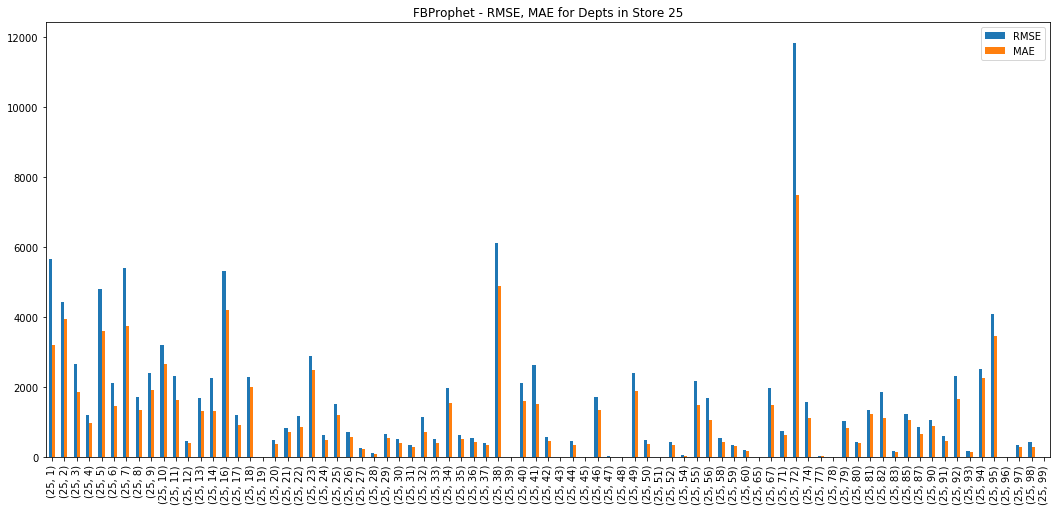

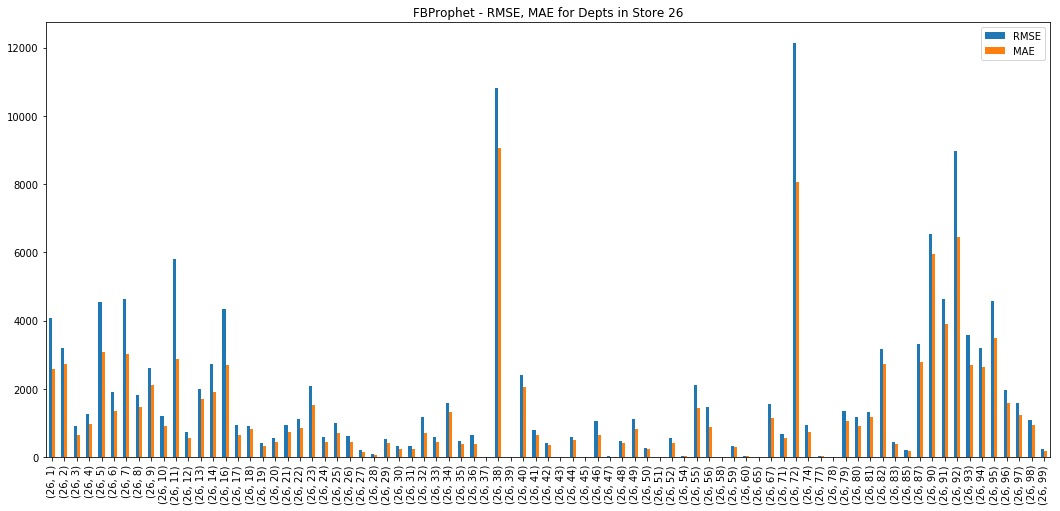

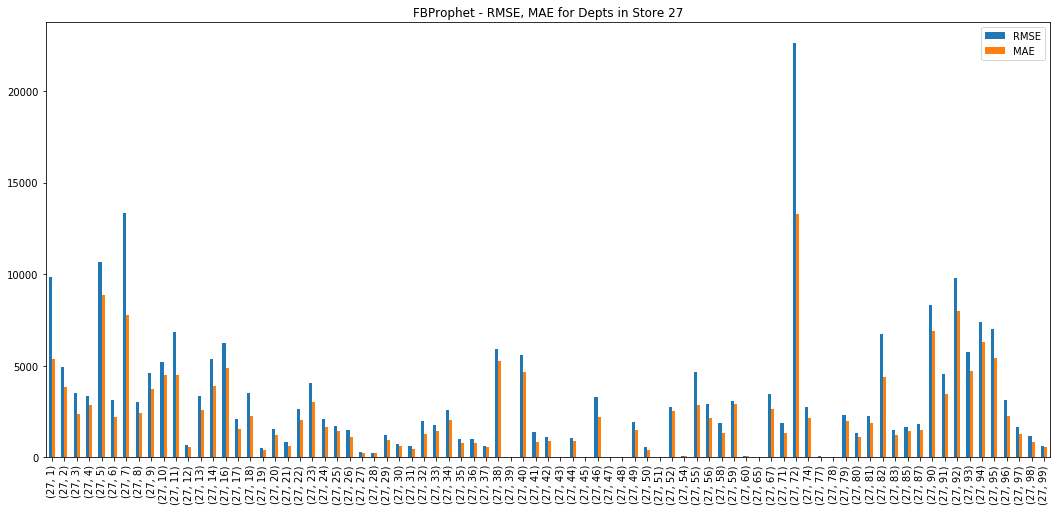

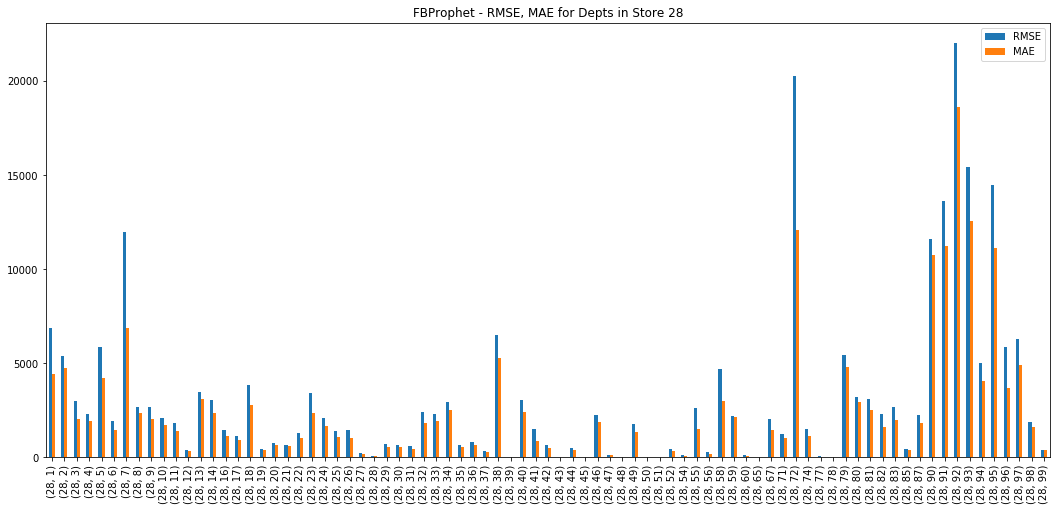

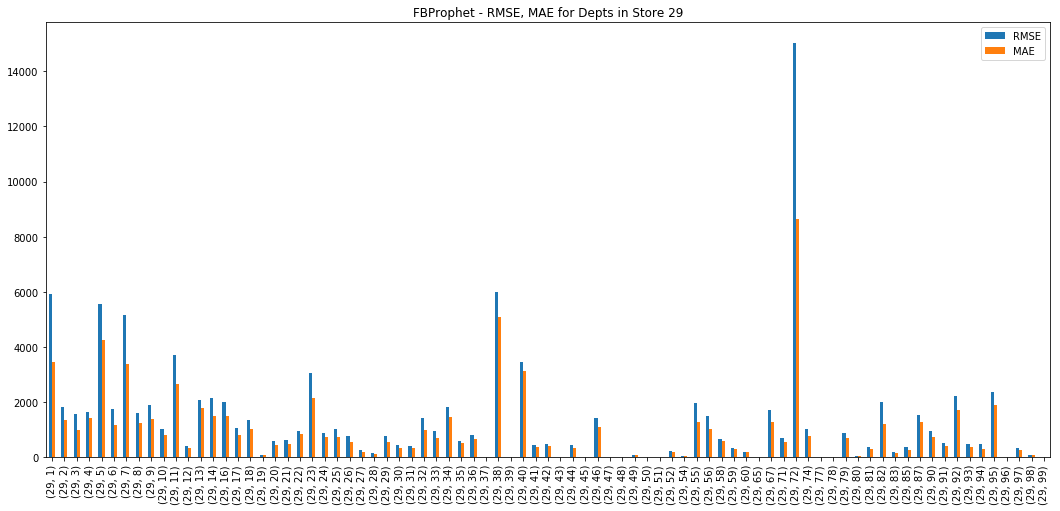

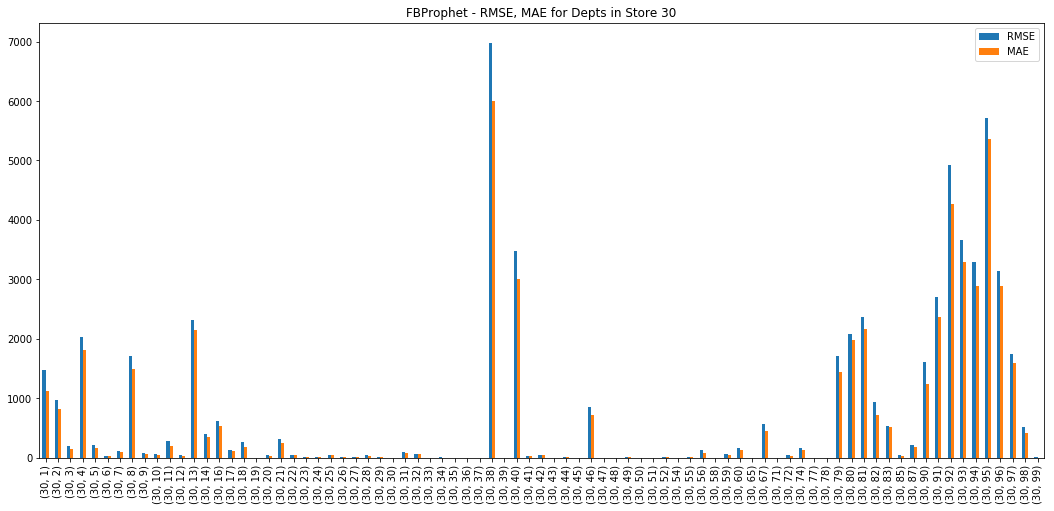

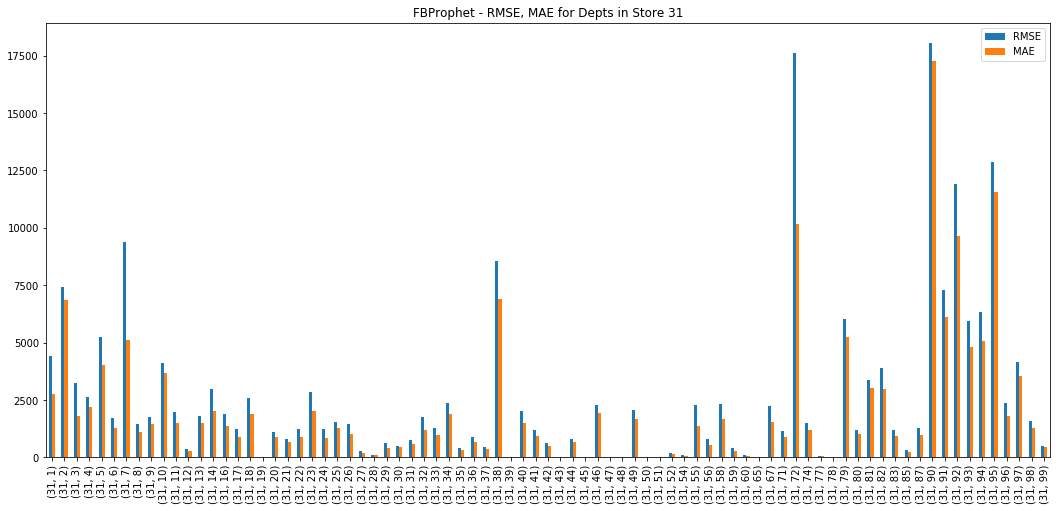

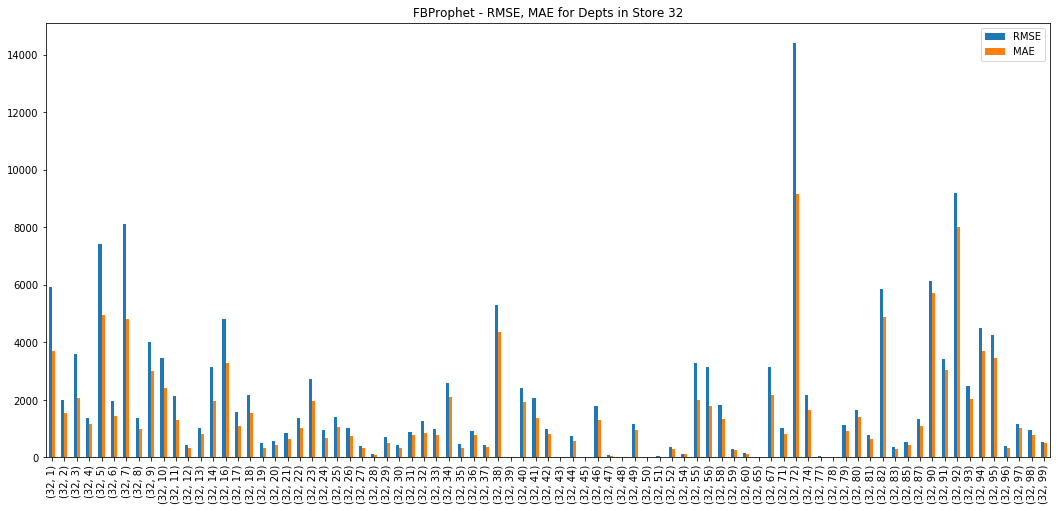

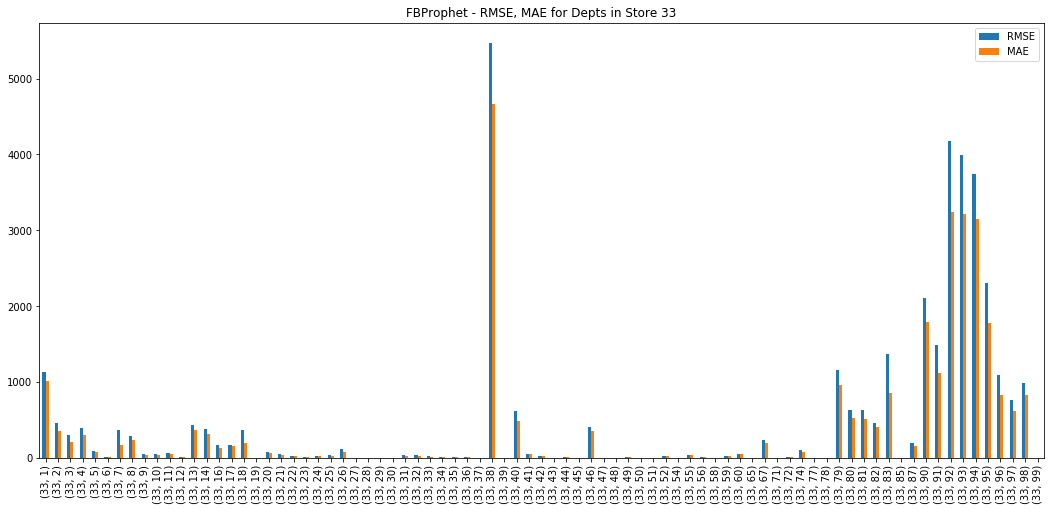

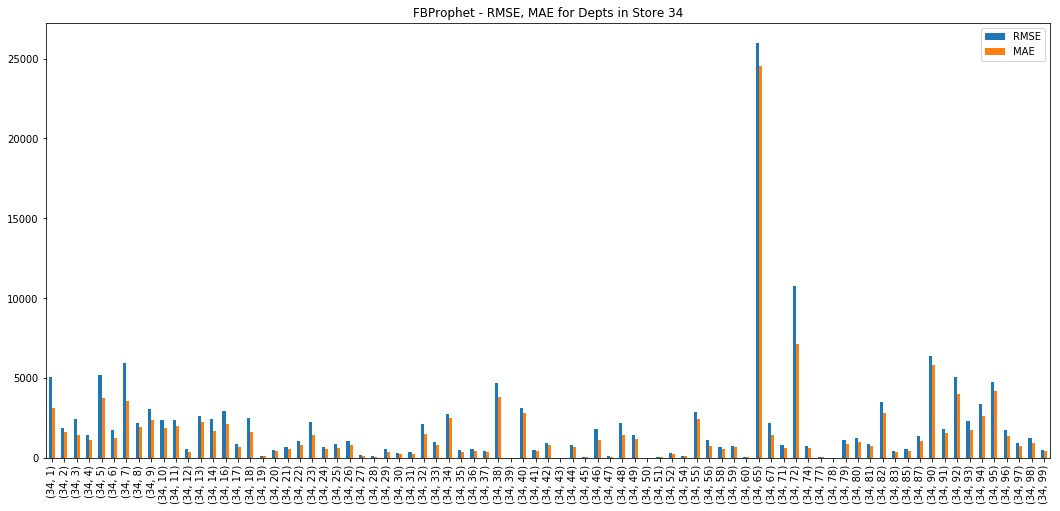

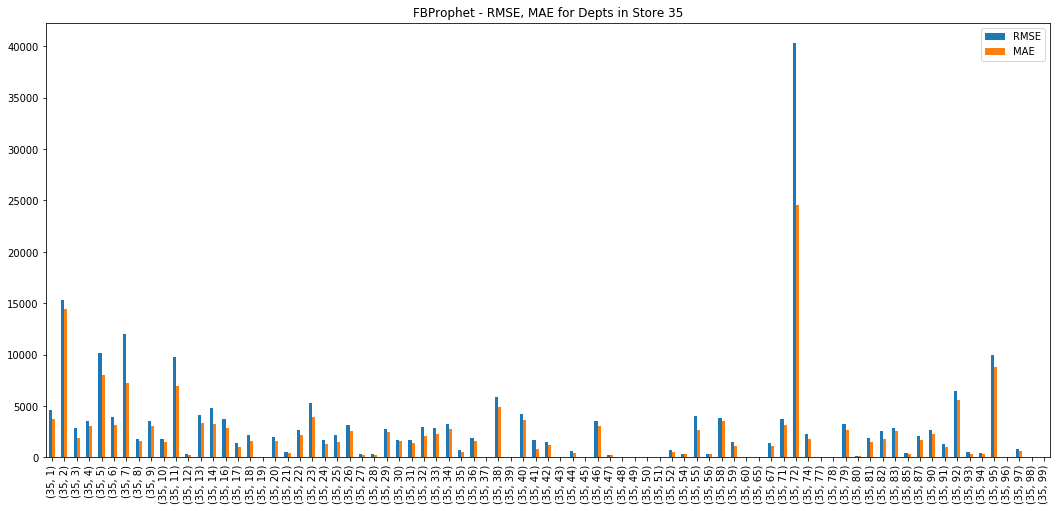

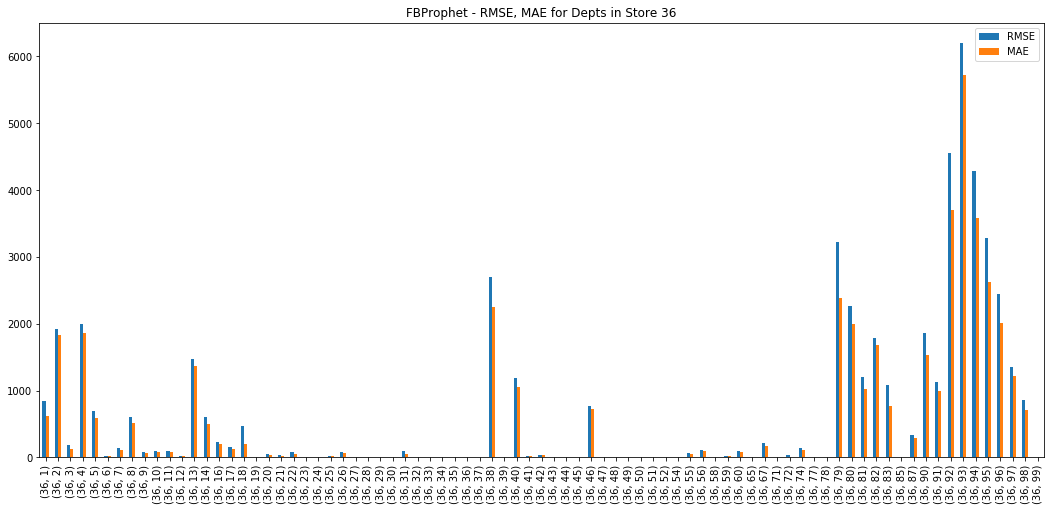

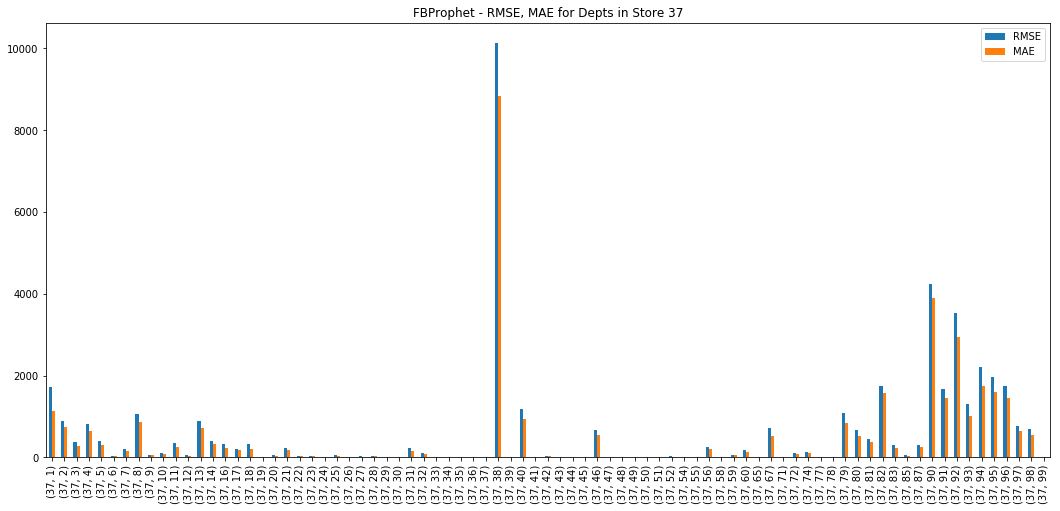

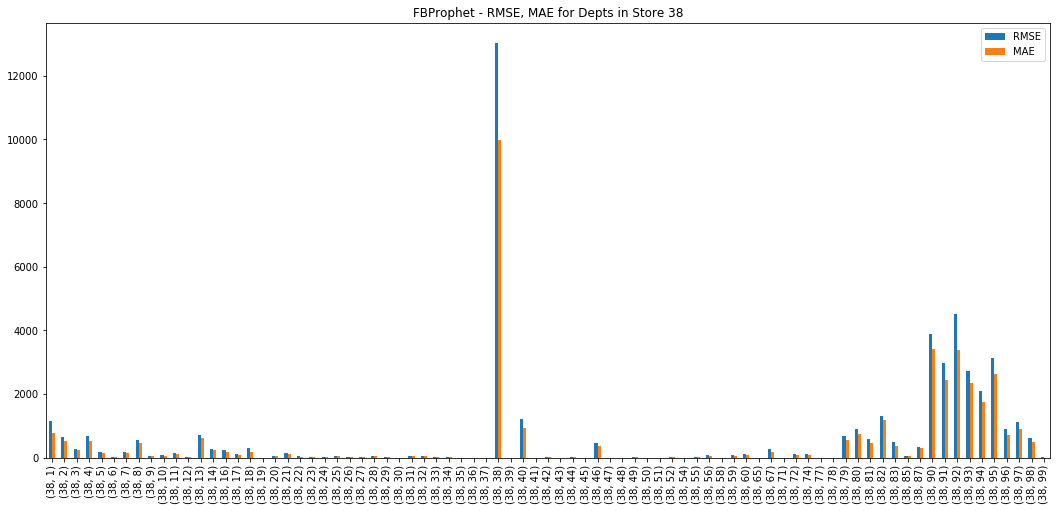

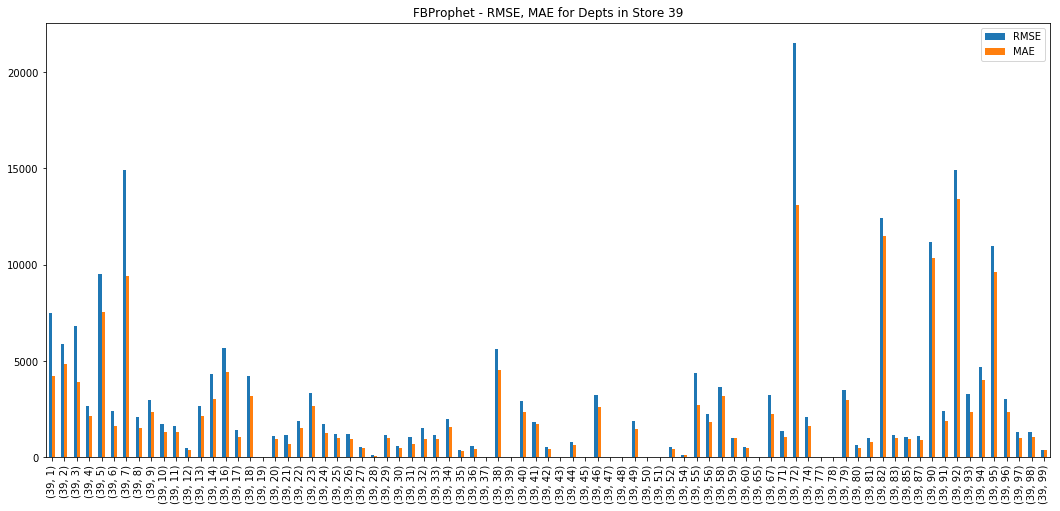

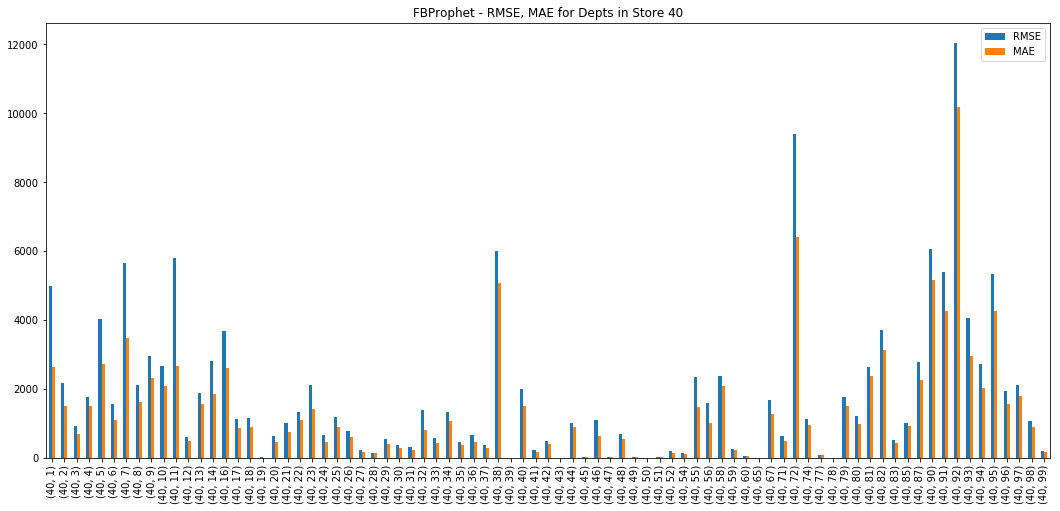

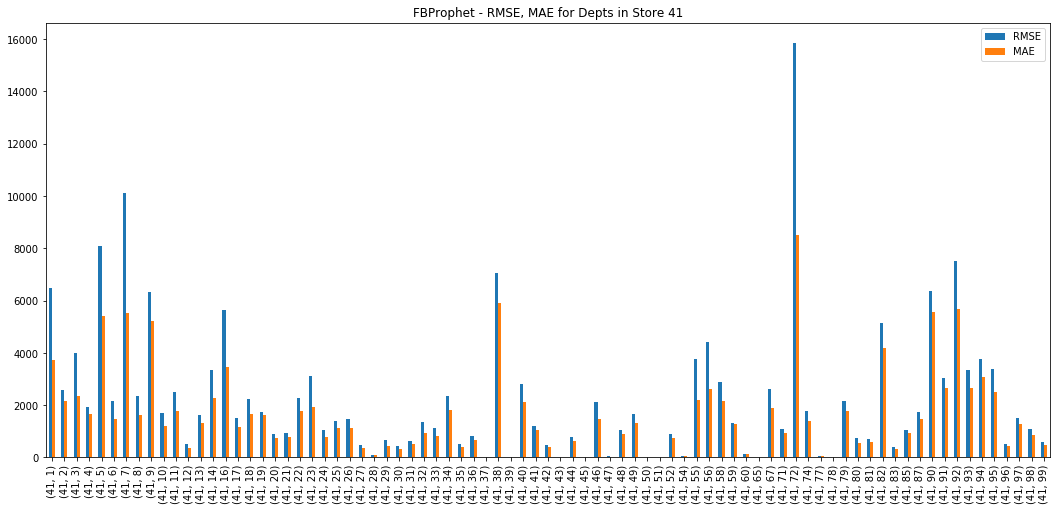

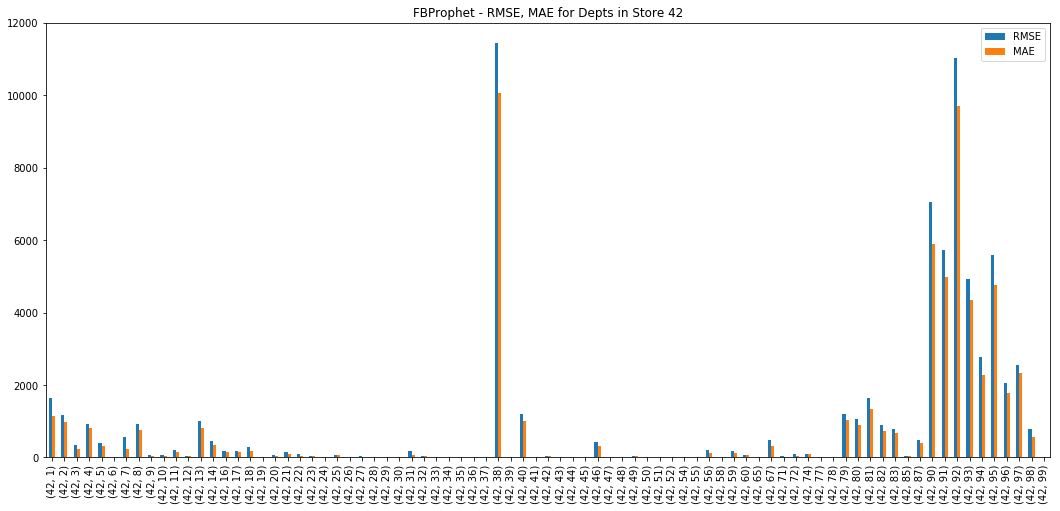

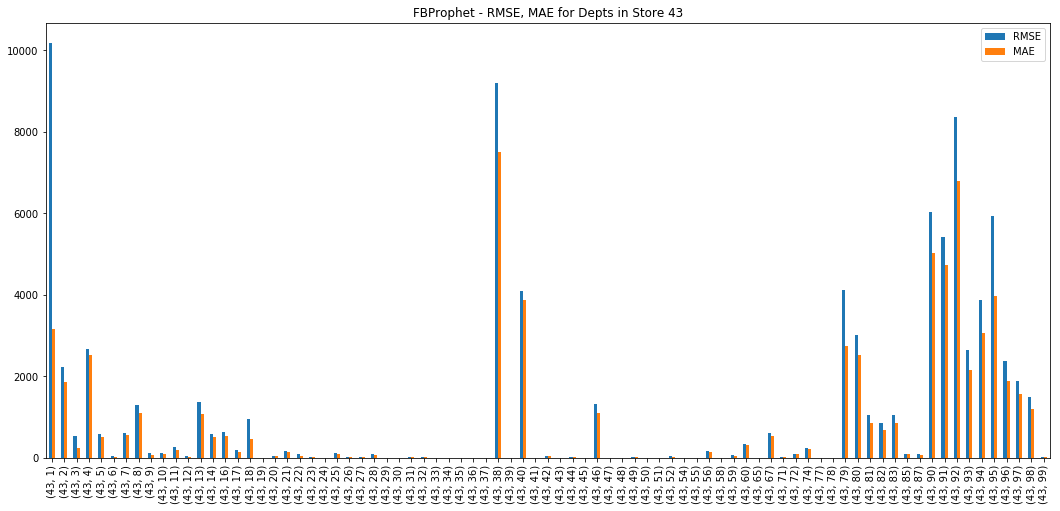

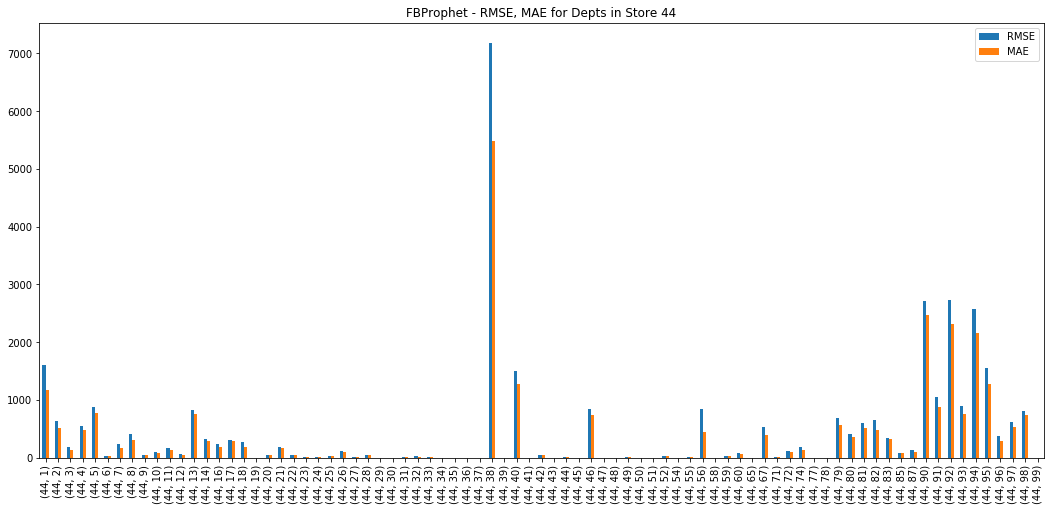

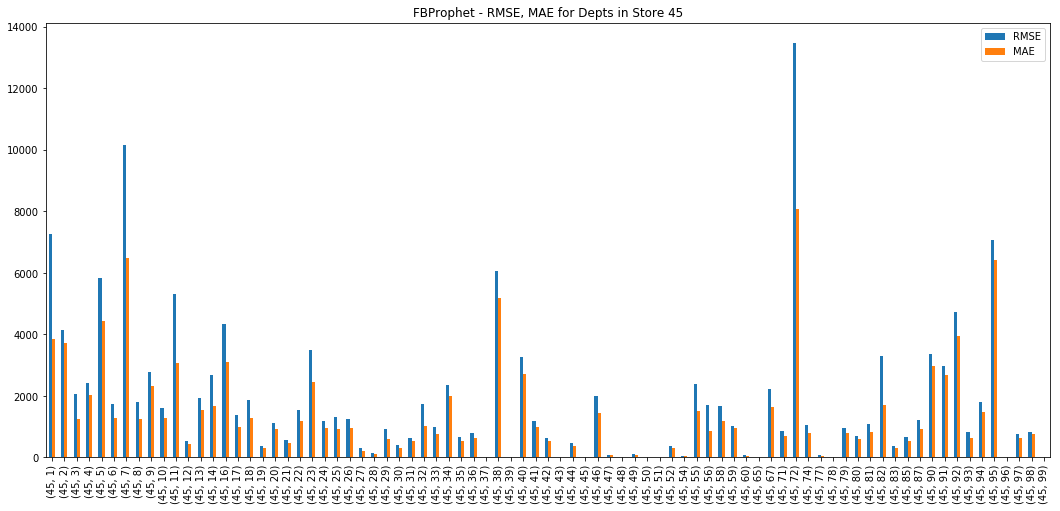

In [25]:
## Plot RMSE, MAE for all depts in a Store
for item in chunks(fbprophet_forecast_results, 81):
    #print(item)
    df = pd.DataFrame(item).T
    ax = df.plot(kind='bar',figsize=(18,8),title='FBProphet - RMSE, MAE for Depts in Store %d' %list(item.keys())[0][0])
    ax.legend(['RMSE', 'MAE']);

## ARIMA

In [26]:
from statsmodels.tsa.stattools import adfuller#, kpss
#from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import collections
import itertools
from itertools import product
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
#import sys

C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [27]:
alldata = pd.read_csv('train.csv', header=0, parse_dates=True, index_col=2)

In [28]:
alldata.head()

,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2010-02-05,1,1,24924.50,False
2010-02-12,1,1,46039.49,True
2010-02-19,1,1,41595.55,False
2010-02-26,1,1,19403.54,False
2010-03-05,1,1,21827.90,False


In [29]:
alldata.tail()

,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2012-09-28,45,98,508.37,False
2012-10-05,45,98,628.10,False
2012-10-12,45,98,1061.02,False
2012-10-19,45,98,760.01,False
2012-10-26,45,98,1076.80,False


In [30]:
alldata.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 421570 entries, 2010-02-05 to 2012-10-26
Data columns (total 4 columns):
Store           421570 non-null int64
Dept            421570 non-null int64
Weekly_Sales    421570 non-null float64
IsHoliday       421570 non-null bool
dtypes: bool(1), float64(1), int64(2)
memory usage: 13.3 MB


In [31]:
stores_all = alldata['Store'].unique()
depts_all = alldata['Dept'].unique()

In [32]:
print(stores_all)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45]


In [33]:
print(depts_all)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 16 17 18 19 20 21 22 23 24 25 26
 27 28 29 30 31 32 33 34 35 36 37 38 40 41 42 44 45 46 47 48 49 51 52 54 55
 56 58 59 60 67 71 72 74 77 78 79 80 81 82 83 85 87 90 91 92 93 94 95 96 97
 98 99 39 50 43 65]


### EDA

In [34]:
## define a function to visualize the sales data for stores and depts

def eda_sales(df, store_locations, departments):
    nrow = len(store_locations)
    ncol = len(departments)
    
    fig,ax = plt.subplots(nrow,ncol)
    r = 0
    c = 0
    
    for store in store_locations:
        c = 0
        for dept in departments:
            df_str_dept = df[(df['Store']==store) & (df['Dept']==dept)][['Weekly_Sales']]
            df_str_dept['Weekly_Sales'].plot(ax=ax[r,c], sharey=True,figsize=(18,18),title='Weekly Sales for Store %d - Dept %d' %(store,dept))        
            c += 1
            plt.tight_layout()
                                               
        r += 1                                 
    

### Plot Weekly Sales for Store - Dept

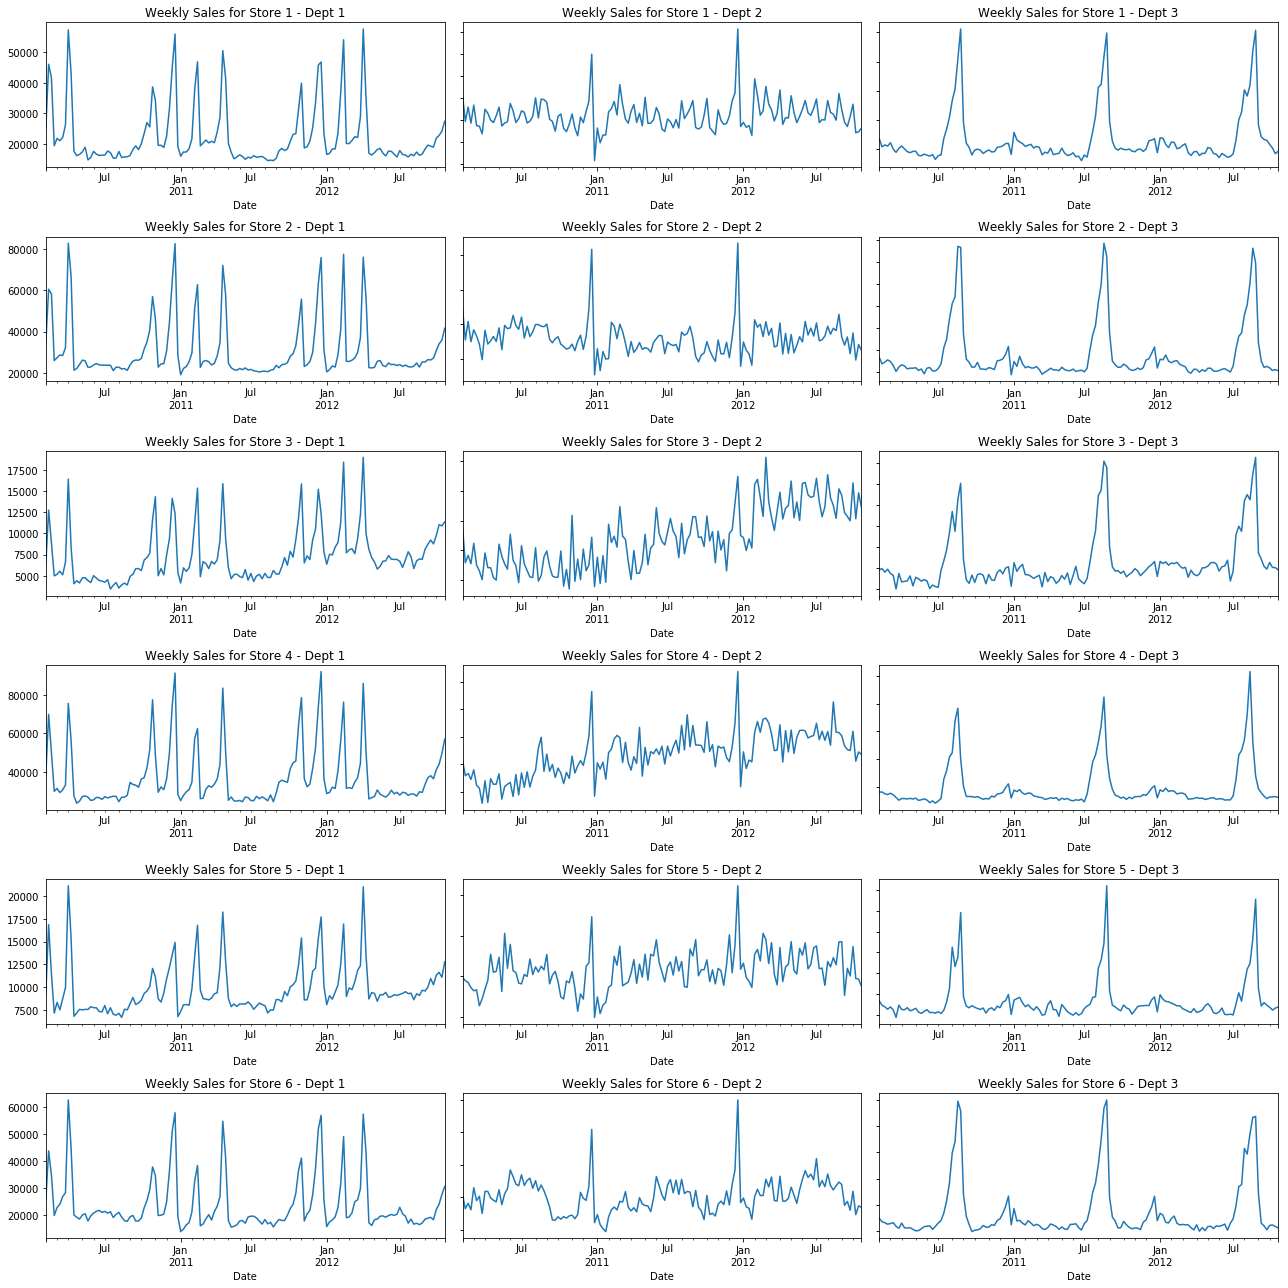

In [35]:
eda_sales(alldata,store_locations=[1,2,3,4,5,6],departments=[1,2,3])

The graph sales of given departments in the different stores look similar.
Eg. Dept 1 in Stores 1 through 6 have similar spikes/seasonality

#### Augmented Dickey Fuller test to check stationarity of time series:

In [36]:
## Augmented Dickey Fuller test to check stationarity of time series:
def adf_test(df, store_locations, departments):
    adf_results = collections.defaultdict(list)
    
    for store in store_locations:
        for dept in departments:
            df_str_dept = df[(df['Store']==store) & (df['Dept']==dept)][['Weekly_Sales']]
            y = df_str_dept['Weekly_Sales']
            dftest = adfuller(y, autolag='AIC')            
            adf_results[(store,dept)].append('Test Statistic: ''%f' %(dftest[0]))
            adf_results[(store,dept)].append('p-value: ''%f' %(dftest[1]))
            adf_results[(store,dept)].append('#Lags used: ''%d' %(dftest[2]))
            adf_results[(store,dept)].append("Number of observations used: '%d'" %(dftest[3]))
            adf_results[(store,dept)].append("Critical Values: ")
            for k, v in dftest[4].items():
                adf_results[(store,dept)].append('%s : ''%.3f' %(k,v))
                if (k == '5%') & (dftest[0] > v) & (dftest[1] > 0.05):  
                    adf_results[(store,dept)].append('****** Take First diff ******')                    
            
    return adf_results

#### Perform Augmented Dickey Fuller test for Store 1, Dept 1

In [37]:
adf_result = adf_test(alldata,store_locations=[1],departments=[1])

In [38]:
adf_result

defaultdict(list,
            {(1, 1): ['Test Statistic: -2.522164',
              'p-value: 0.110174',
              '#Lags used: 6',
              "Number of observations used: '136'",
              'Critical Values: ',
              '1% : -3.479',
              '5% : -2.883',
              '****** Take First diff ******',
              '10% : -2.578']})

#### ARIMA model

We can use the ARIMA (autoregressive integrated moving average) model to fit the time series data in order to predict future points in the series.

There are three distinct integers (p, d, q) that are used to parametrize ARIMA models.
These three parameters account for seasonality, trend, and noise in datasets

p is the auto-regressive part of the model. It allows us to incorporate the effect of past values into our model.
d is the integrated part of the model. This includes terms in the model that incorporate the amount of differencing.
q is the moving average part of the model. This allows us to set the error of our model as a linear combination of the error values observed at previous time points in the past.

Since we have time series with seasonal effects, we can use the seasonal ARIMA, which is denoted as 
ARIMA(p,d,q)(P,D,Q)s. Here, (p, d, q) are the non-seasonal parameters, while (P, D, Q) follow the same definition but are applied to the seasonal component of the time series. 
The term s is the periodicity of the time series (4 for quarterly periods, 12 for yearly periods, etc.).

### Plot the Autocorrelation and Partial Autocorrelation graphs

After a time series has been stationarized by differencing, the next step in fitting an ARIMA model is to determine whether AR or MA terms are needed to correct any autocorrelation that remains in the differenced series. 
By looking at the autocorrelation function (ACF) and partial autocorrelation (PACF) plots of the differenced series, you can tentatively identify the numbers of AR and/or MA terms that are needed. 
The ACF graph is a bar chart of the coefficients of correlation between a time series and lags of itself. 
The PACF plot is a plot of the partial correlation coefficients between the series and lags of itself.

In [39]:
def plot_acf_pacf(df,store_locations,departments,lags=10):
    nrow = len(store_locations)*2
    ncol = len(departments)
    
    fig,ax = plt.subplots(nrow,ncol,figsize=(12,8))
    r = 0
    c = 0
    for store in store_locations:
        c=0
        for dept in departments:
            df_str_dept = df[(df['Store']==store) & (df['Dept']==dept)][['Weekly_Sales']]
            y = df_str_dept['Weekly_Sales']
            smt.graphics.plot_acf(y, lags=10,title='Autocorrelation for Store %d, Dept %d' %(store,dept),ax=ax[r,c])
            smt.graphics.plot_pacf(y, lags=10,title='Partial Autocorrelation for Store %d, Dept %d' %(store,dept),ax=ax[r,c+1]);            
            r += 1
            plt.tight_layout()

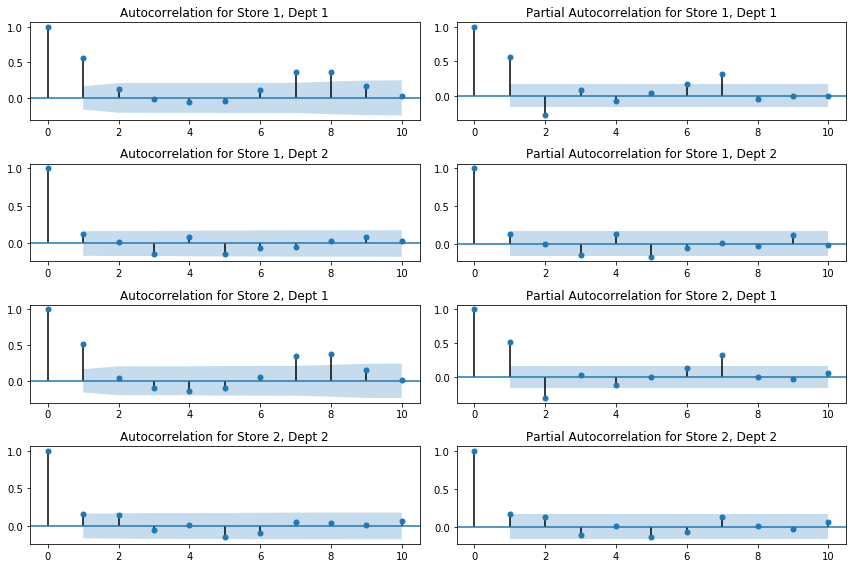

In [40]:
plot_acf_pacf(alldata,store_locations=[1,2],departments=[1,2])

Looking at Store 1, Dept 1:
From PACF: since the first significant spike in the blue shaded area is at 2 (negative correlation), we can say that the p = 2
From ACF: since the first significant spike iin the blue shaded area is ar 2, we can say that q = 2
And since ADF test showed that the times series became stationary when taking the 1st difference, d = 1.

So, lets use the range(0,2) to come up with the optimal parameters for p and q using grid search

In [41]:
def forecast_sales_arima(df, store_locations, departments):
    
    pdq_dict = collections.defaultdict(list)    
    result_dict = collections.defaultdict(list)   
    
    
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, d, q))]    
    try:
        for store in store_locations:
            for dept in departments:
                df_str_dept = df[(df['Store']==store) & (df['Dept']==dept)][['Weekly_Sales']]
                daterange = pd.date_range(start=df.index.min().date(),end=df.index.max().date(), freq='W-FRI')             
                missing = sorted(set(daterange)  - set(df_str_dept.index))            
                
                if(len(missing) >= 1):                
                    df_str_dept = df_str_dept.reindex(daterange, fill_value=0) ## fill missing weekdays with 0
                    y = df_str_dept['Weekly_Sales']                
                else:                
                    y = df_str_dept['Weekly_Sales']
                
                best_aic = np.inf
                best_pdq = None
                best_seasonal_pdq = None
                tmp_model = None
                best_mdl = None
                train_size = int(len(y) * 0.70)
                y_train, y_test = y[0:train_size], y[train_size:len(y)]
                    
                if(all(v == 0 for v in y_train)):                
                    print("All values in the series are 0 for Store %d, Dept %d" %(store, dept))
                    rmse = 0
                    mae = 0
                else:                                                          
                    for param in pdq:
                        for param_seasonal in seasonal_pdq:
                            try:
                                tmp_mdl = sm.tsa.statespace.SARIMAX(y_train,
                                                order = param,
                                                seasonal_order = param_seasonal,
                                                enforce_stationarity=True,
                                                enforce_invertibility=True)
                                res = tmp_mdl.fit()
                                if res.aic < best_aic:
                                    best_aic = res.aic
                                    best_pdq = param
                                    best_seasonal_pdq = param_seasonal
                                    best_mdl = tmp_mdl
                            except:
                                   # print("Unexpected error:", sys.exc_info()[0])
                                continue
                    
                    #print(best_seasonal_pdq)
                    model = sm.tsa.statespace.SARIMAX(y_train, order = best_pdq,seasonal_order = best_seasonal_pdq
                                                  ,enforce_stationarity=True
                                              ,enforce_invertibility=True)
                    result = model.fit()
                    result.summary()
            
            
            ## Out of sample prediction
            ## Predict for train_df and test_df timeframe
                    forecast_out = result.predict(start=pd.to_datetime(y_train.index[0].date()), 
                              end=pd.to_datetime(y_test.index[-1].date()),
                              dynamic=False, full_results=True)
                    
                    forecast_out.head()
                    
            ## Create metrics_df that holds forecasted values for test_df timeframe and original test_df
                    metrics_df = pd.concat((forecast_out[y_test.index[0]:y_test.index[-1]], y_test), axis=1)
                    metrics_df.columns = ['y_hat', 'y_true']            
            
                    mse = mean_squared_error(metrics_df['y_true'], metrics_df['y_hat'])
                    rmse = np.sqrt(mse)
                    mae = mean_absolute_error(metrics_df['y_true'], metrics_df['y_hat'])
            
                result_dict[(store,dept)].append(rmse)
                result_dict[(store,dept)].append(mae)
                
    
    except TypeError: 
        print('Value Error store %d, dept %d' %(store, dept))
    return result_dict    

In [42]:
%%time
arima_forecast_results = forecast_sales_arima(alldata, store_locations=stores_all,departments=depts_all)

C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages

All values in the series are 0 for Store 1, Dept 39
All values in the series are 0 for Store 1, Dept 50
All values in the series are 0 for Store 1, Dept 43
All values in the series are 0 for Store 1, Dept 65


C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages

All values in the series are 0 for Store 2, Dept 50
All values in the series are 0 for Store 2, Dept 43
All values in the series are 0 for Store 2, Dept 65


C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


All values in the series are 0 for Store 3, Dept 37


C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


All values in the series are 0 for Store 3, Dept 48


C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


All values in the series are 0 for Store 3, Dept 58


C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


All values in the series are 0 for Store 3, Dept 83
All values in the series are 0 for Store 3, Dept 93
All values in the series are 0 for Store 3, Dept 99
All values in the series are 0 for Store 3, Dept 39
All values in the series are 0 for Store 3, Dept 50
All values in the series are 0 for Store 3, Dept 43
All values in the series are 0 for Store 3, Dept 65


C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages

All values in the series are 0 for Store 4, Dept 50
All values in the series are 0 for Store 4, Dept 43
All values in the series are 0 for Store 4, Dept 65


C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


All values in the series are 0 for Store 5, Dept 37
All values in the series are 0 for Store 5, Dept 48


C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


All values in the series are 0 for Store 5, Dept 83
All values in the series are 0 for Store 5, Dept 93
All values in the series are 0 for Store 5, Dept 99
All values in the series are 0 for Store 5, Dept 39
All values in the series are 0 for Store 5, Dept 50
All values in the series are 0 for Store 5, Dept 43
All values in the series are 0 for Store 5, Dept 65


C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages

All values in the series are 0 for Store 6, Dept 39
All values in the series are 0 for Store 6, Dept 50
All values in the series are 0 for Store 6, Dept 43
All values in the series are 0 for Store 6, Dept 65


C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


All values in the series are 0 for Store 7, Dept 37


C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


All values in the series are 0 for Store 7, Dept 99
All values in the series are 0 for Store 7, Dept 39
All values in the series are 0 for Store 7, Dept 50
All values in the series are 0 for Store 7, Dept 43
All values in the series are 0 for Store 7, Dept 65


C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


All values in the series are 0 for Store 8, Dept 48


C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


All values in the series are 0 for Store 8, Dept 96
All values in the series are 0 for Store 8, Dept 39
All values in the series are 0 for Store 8, Dept 50
All values in the series are 0 for Store 8, Dept 43
All values in the series are 0 for Store 8, Dept 65


C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


All values in the series are 0 for Store 9, Dept 37


C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


All values in the series are 0 for Store 9, Dept 58
All values in the series are 0 for Store 9, Dept 78
All values in the series are 0 for Store 9, Dept 83
All values in the series are 0 for Store 9, Dept 99
All values in the series are 0 for Store 9, Dept 39
All values in the series are 0 for Store 9, Dept 50
All values in the series are 0 for Store 9, Dept 43
All values in the series are 0 for Store 9, Dept 65


C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages

All values in the series are 0 for Store 10, Dept 99
All values in the series are 0 for Store 10, Dept 39
All values in the series are 0 for Store 10, Dept 43
All values in the series are 0 for Store 10, Dept 65


C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages

All values in the series are 0 for Store 11, Dept 39
All values in the series are 0 for Store 11, Dept 43
All values in the series are 0 for Store 11, Dept 65


C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


All values in the series are 0 for Store 12, Dept 37


C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


All values in the series are 0 for Store 12, Dept 48


C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


All values in the series are 0 for Store 12, Dept 99
All values in the series are 0 for Store 12, Dept 39
All values in the series are 0 for Store 12, Dept 50
All values in the series are 0 for Store 12, Dept 43
All values in the series are 0 for Store 12, Dept 65


C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


All values in the series are 0 for Store 13, Dept 39
All values in the series are 0 for Store 13, Dept 65


C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


All values in the series are 0 for Store 14, Dept 37
All values in the series are 0 for Store 14, Dept 48


C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


All values in the series are 0 for Store 14, Dept 39
All values in the series are 0 for Store 14, Dept 65


C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages

All values in the series are 0 for Store 15, Dept 99
All values in the series are 0 for Store 15, Dept 39
All values in the series are 0 for Store 15, Dept 65


C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


All values in the series are 0 for Store 16, Dept 37


C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


All values in the series are 0 for Store 16, Dept 99
All values in the series are 0 for Store 16, Dept 39
All values in the series are 0 for Store 16, Dept 50
All values in the series are 0 for Store 16, Dept 43
All values in the series are 0 for Store 16, Dept 65


C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


All values in the series are 0 for Store 17, Dept 37
All values in the series are 0 for Store 17, Dept 99
All values in the series are 0 for Store 17, Dept 39
All values in the series are 0 for Store 17, Dept 50
All values in the series are 0 for Store 17, Dept 43
All values in the series are 0 for Store 17, Dept 65
All values in the series are 0 for Store 18, Dept 37


C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


All values in the series are 0 for Store 18, Dept 43
All values in the series are 0 for Store 18, Dept 65


C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages

All values in the series are 0 for Store 19, Dept 39
All values in the series are 0 for Store 19, Dept 43
All values in the series are 0 for Store 19, Dept 65


C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages

All values in the series are 0 for Store 20, Dept 39
All values in the series are 0 for Store 20, Dept 43
All values in the series are 0 for Store 20, Dept 65


C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages

All values in the series are 0 for Store 21, Dept 37


C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


All values in the series are 0 for Store 21, Dept 99
All values in the series are 0 for Store 21, Dept 39
All values in the series are 0 for Store 21, Dept 50
All values in the series are 0 for Store 21, Dept 43
All values in the series are 0 for Store 21, Dept 65


C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


All values in the series are 0 for Store 22, Dept 37


C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages

All values in the series are 0 for Store 22, Dept 39
All values in the series are 0 for Store 22, Dept 50
All values in the series are 0 for Store 22, Dept 43
All values in the series are 0 for Store 22, Dept 65
All values in the series are 0 for Store 23, Dept 37


C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


All values in the series are 0 for Store 23, Dept 99
All values in the series are 0 for Store 23, Dept 39
All values in the series are 0 for Store 23, Dept 43
All values in the series are 0 for Store 23, Dept 65


C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


All values in the series are 0 for Store 24, Dept 48


C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages

All values in the series are 0 for Store 24, Dept 39
All values in the series are 0 for Store 24, Dept 43
All values in the series are 0 for Store 24, Dept 65


C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


All values in the series are 0 for Store 25, Dept 96
All values in the series are 0 for Store 25, Dept 99
All values in the series are 0 for Store 25, Dept 39
All values in the series are 0 for Store 25, Dept 43
All values in the series are 0 for Store 25, Dept 65


C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


All values in the series are 0 for Store 26, Dept 37
All values in the series are 0 for Store 26, Dept 58


C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


All values in the series are 0 for Store 26, Dept 39
All values in the series are 0 for Store 26, Dept 43
All values in the series are 0 for Store 26, Dept 65


C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


All values in the series are 0 for Store 27, Dept 48


C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


All values in the series are 0 for Store 27, Dept 43
All values in the series are 0 for Store 27, Dept 65


C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


All values in the series are 0 for Store 28, Dept 48


C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


All values in the series are 0 for Store 28, Dept 39
All values in the series are 0 for Store 28, Dept 50


C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


All values in the series are 0 for Store 28, Dept 65


C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


All values in the series are 0 for Store 29, Dept 37


C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


All values in the series are 0 for Store 29, Dept 99
All values in the series are 0 for Store 29, Dept 39
All values in the series are 0 for Store 29, Dept 50
All values in the series are 0 for Store 29, Dept 43
All values in the series are 0 for Store 29, Dept 65


C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


All values in the series are 0 for Store 30, Dept 19
All values in the series are 0 for Store 30, Dept 30
All values in the series are 0 for Store 30, Dept 35
All values in the series are 0 for Store 30, Dept 36
All values in the series are 0 for Store 30, Dept 37


C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


All values in the series are 0 for Store 30, Dept 45
All values in the series are 0 for Store 30, Dept 47
All values in the series are 0 for Store 30, Dept 48
All values in the series are 0 for Store 30, Dept 51
All values in the series are 0 for Store 30, Dept 54
All values in the series are 0 for Store 30, Dept 58
All values in the series are 0 for Store 30, Dept 71
All values in the series are 0 for Store 30, Dept 77
All values in the series are 0 for Store 30, Dept 78
All values in the series are 0 for Store 30, Dept 39
All values in the series are 0 for Store 30, Dept 50
All values in the series are 0 for Store 30, Dept 43
All values in the series are 0 for Store 30, Dept 65


C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages

All values in the series are 0 for Store 31, Dept 48


C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


All values in the series are 0 for Store 31, Dept 39
All values in the series are 0 for Store 31, Dept 50
All values in the series are 0 for Store 31, Dept 43
All values in the series are 0 for Store 31, Dept 65


C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages

All values in the series are 0 for Store 32, Dept 39
All values in the series are 0 for Store 32, Dept 50
All values in the series are 0 for Store 32, Dept 43
All values in the series are 0 for Store 32, Dept 65
All values in the series are 0 for Store 33, Dept 19
All values in the series are 0 for Store 33, Dept 28
All values in the series are 0 for Store 33, Dept 29
All values in the series are 0 for Store 33, Dept 30
All values in the series are 0 for Store 33, Dept 32
All values in the series are 0 for Store 33, Dept 37
All values in the series are 0 for Store 33, Dept 45
All values in the series are 0 for Store 33, Dept 47
All values in the series are 0 for Store 33, Dept 48
All values in the series are 0 for Store 33, Dept 49
All values in the series are 0 for Store 33, Dept 51
All values in the series are 0 for Store 33, Dept 54
All values in the series are 0 for Store 33, Dept 58
All values in the series are 0 for Store 33, Dept 77
All values in the series are 0 for Store 33, D

C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


All values in the series are 0 for Store 33, Dept 85


C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


All values in the series are 0 for Store 33, Dept 99
All values in the series are 0 for Store 33, Dept 39
All values in the series are 0 for Store 33, Dept 50
All values in the series are 0 for Store 33, Dept 43
All values in the series are 0 for Store 33, Dept 65


C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Value Error store 34, dept 78
Wall time: 5h 57min 45s


#### Write the RMSE and MAE to a csv

In [65]:
#write results to csv
with open('arima_results.csv', 'w', newline='') as f:
    writer = csv.writer(f) 
    writer.writerow(['Store', 'Dept', 'RMSE', 'MAE'])
    for keys,values in arima_forecast_results.items():        
        writer.writerow(list(keys)+values)

C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


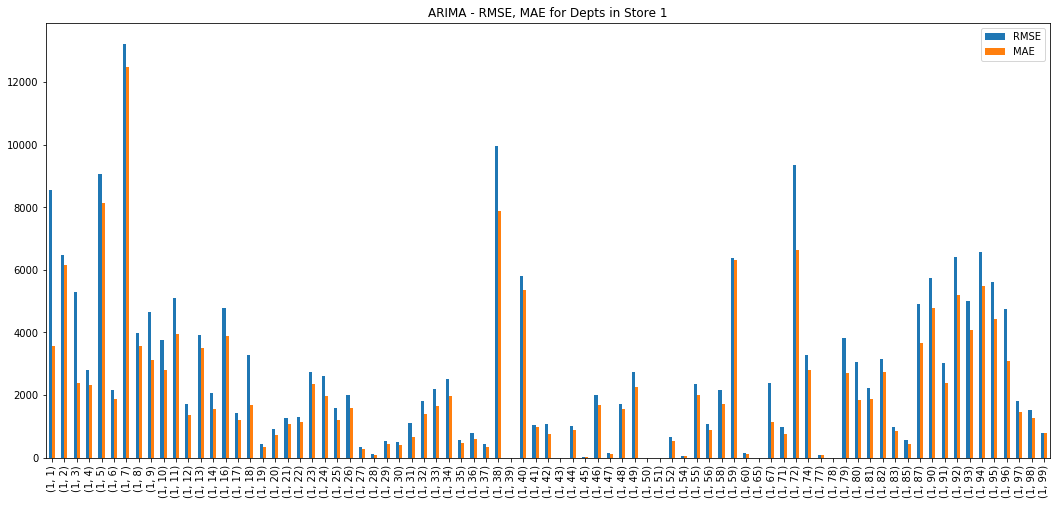

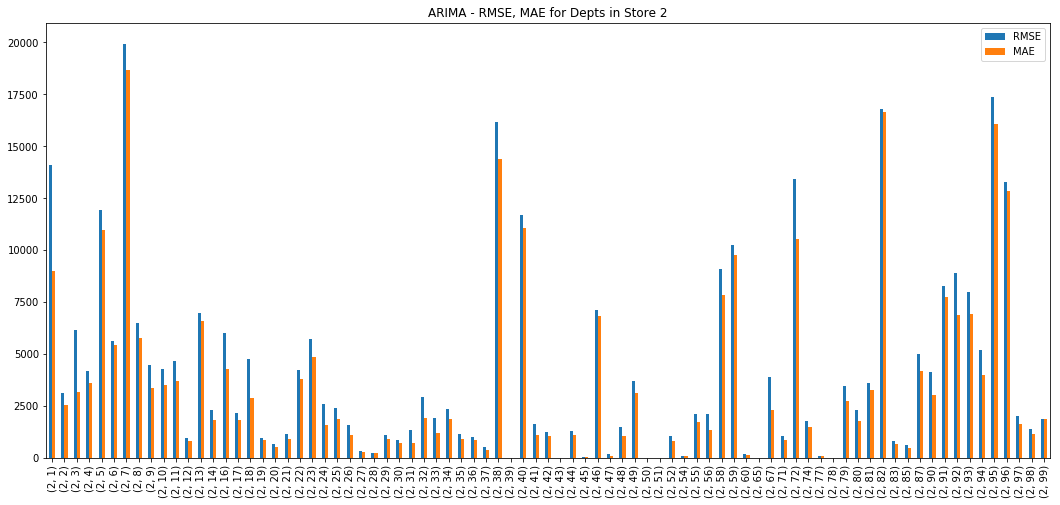

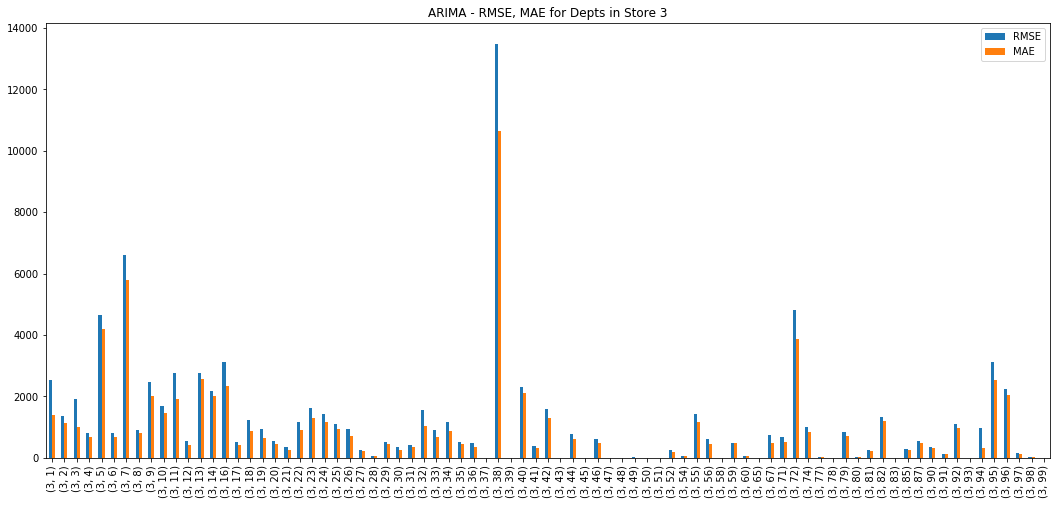

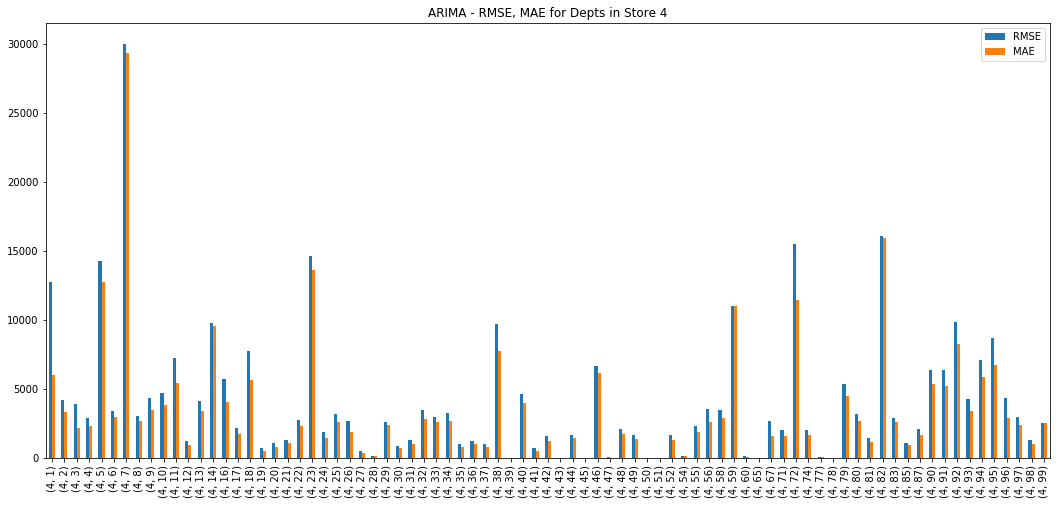

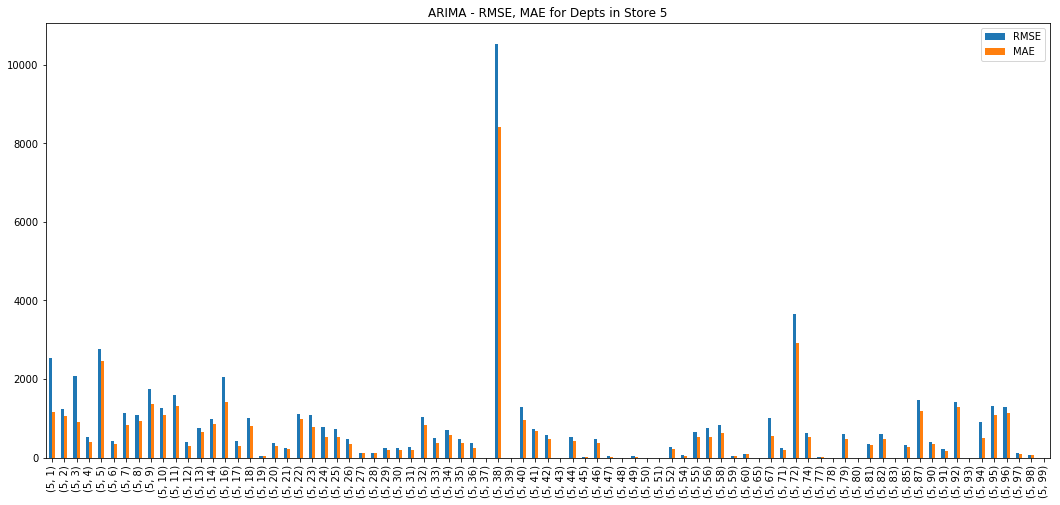

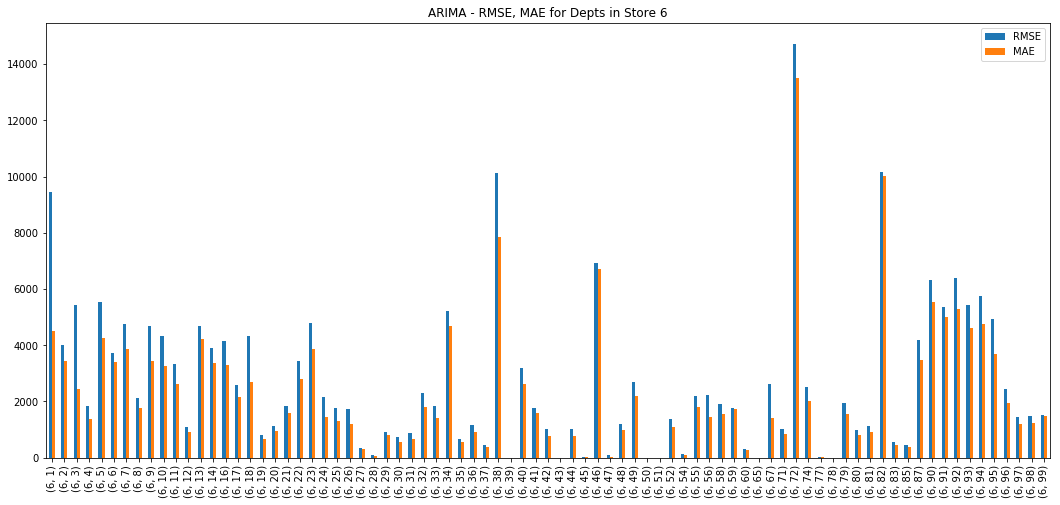

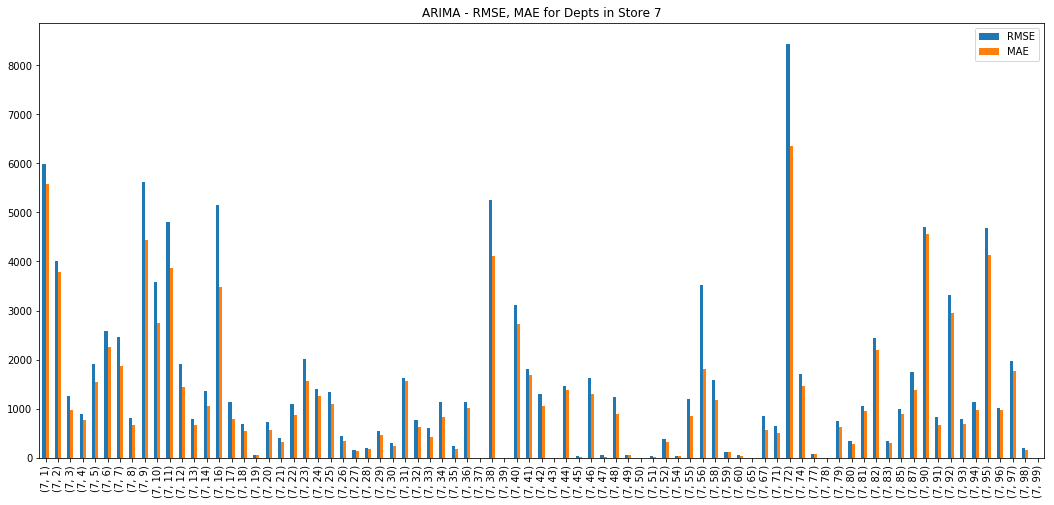

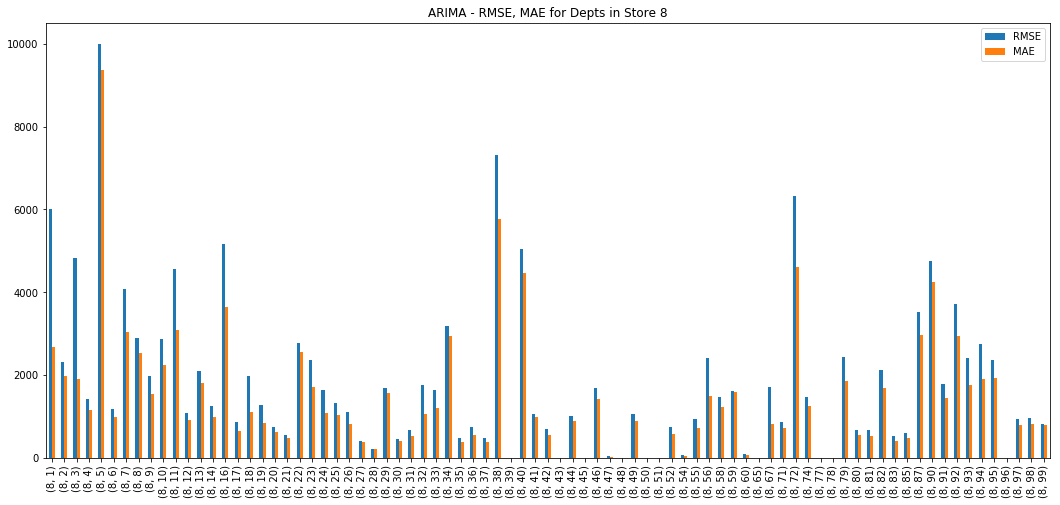

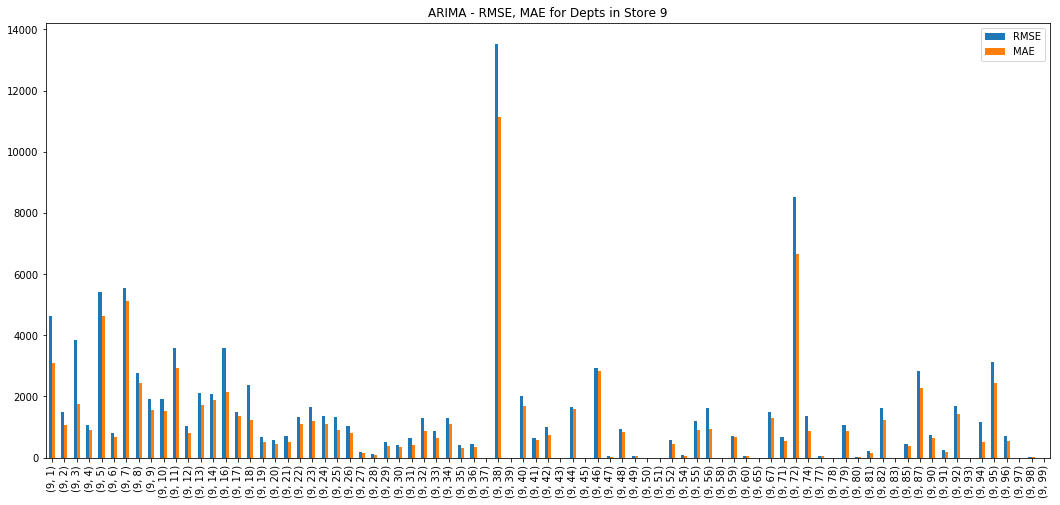

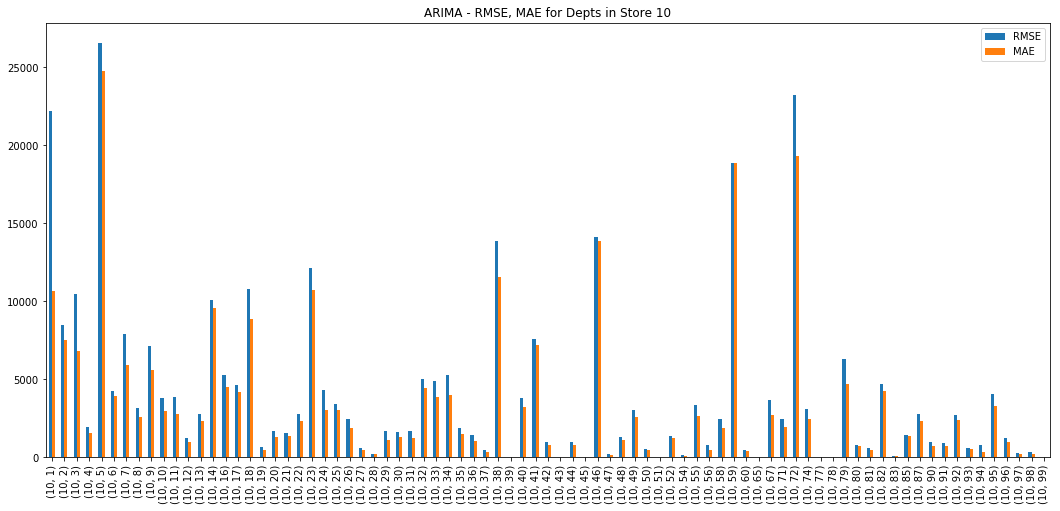

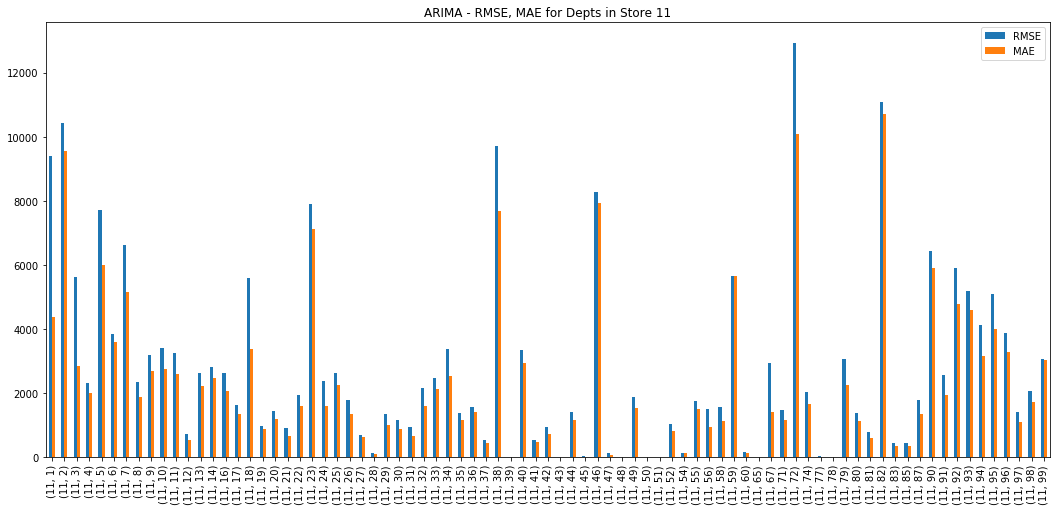

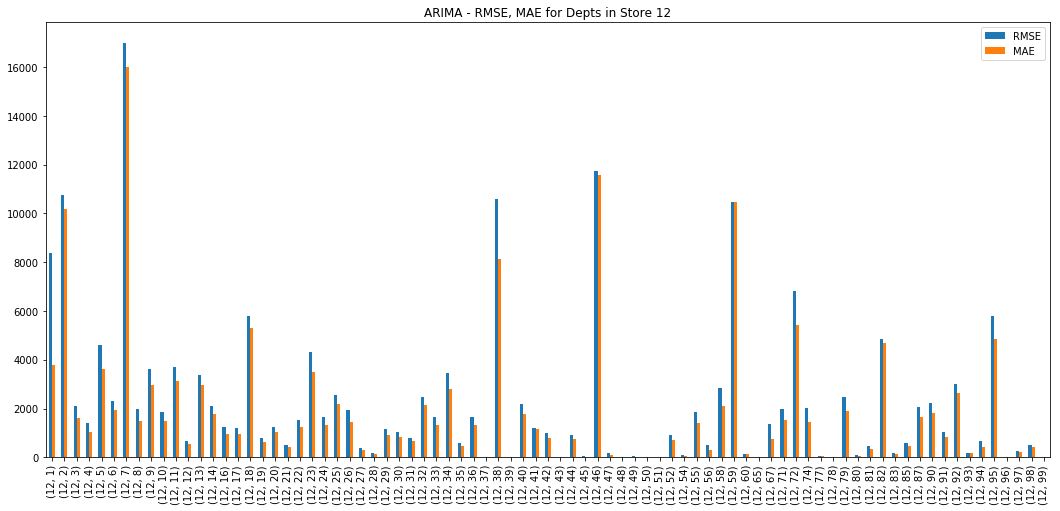

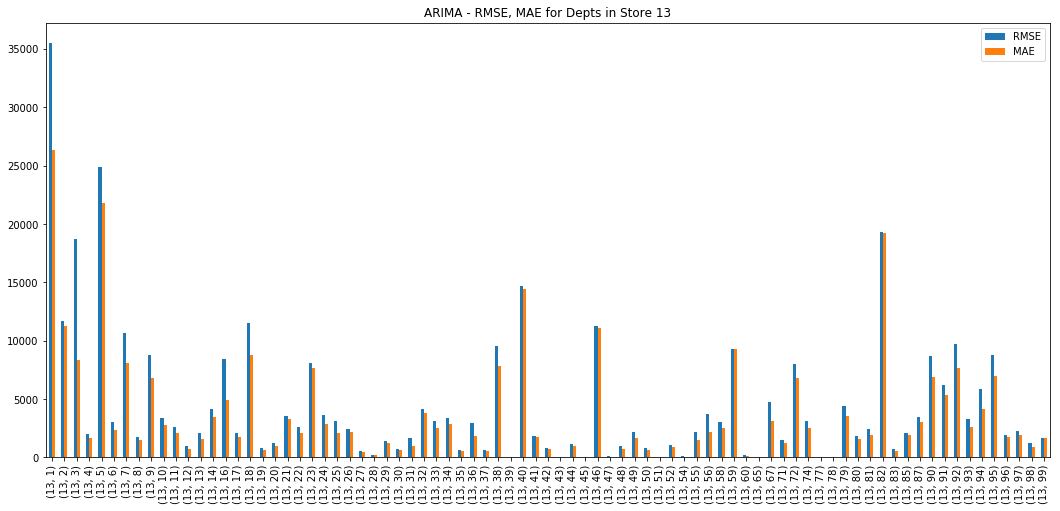

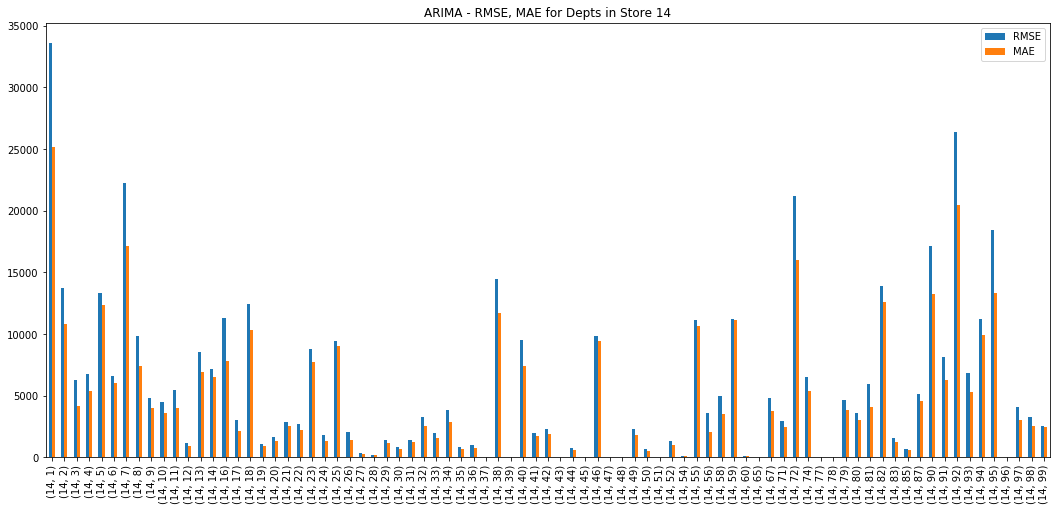

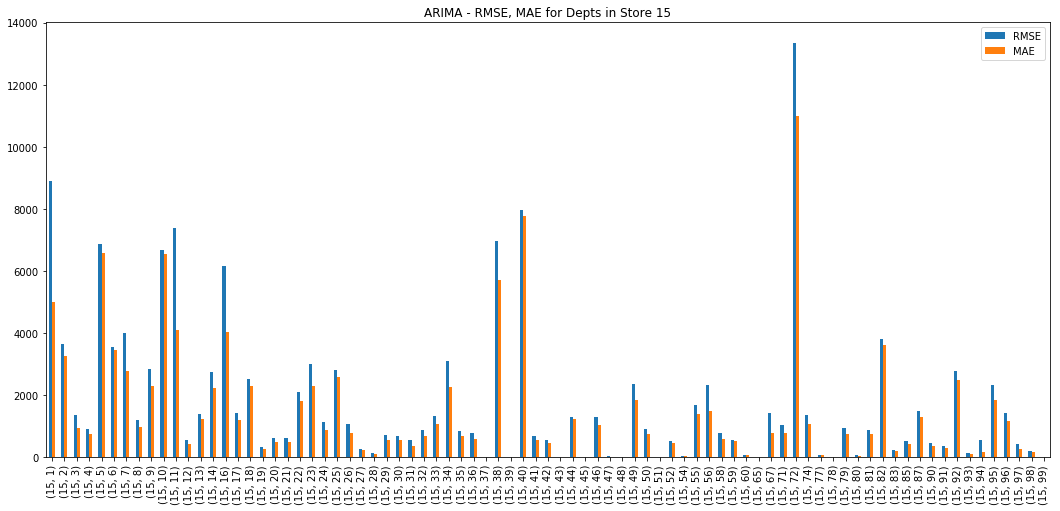

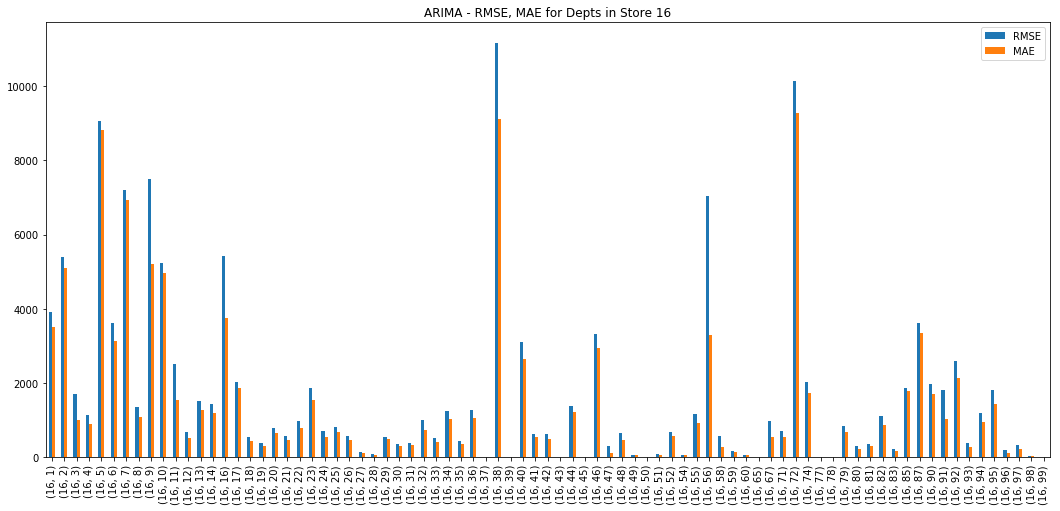

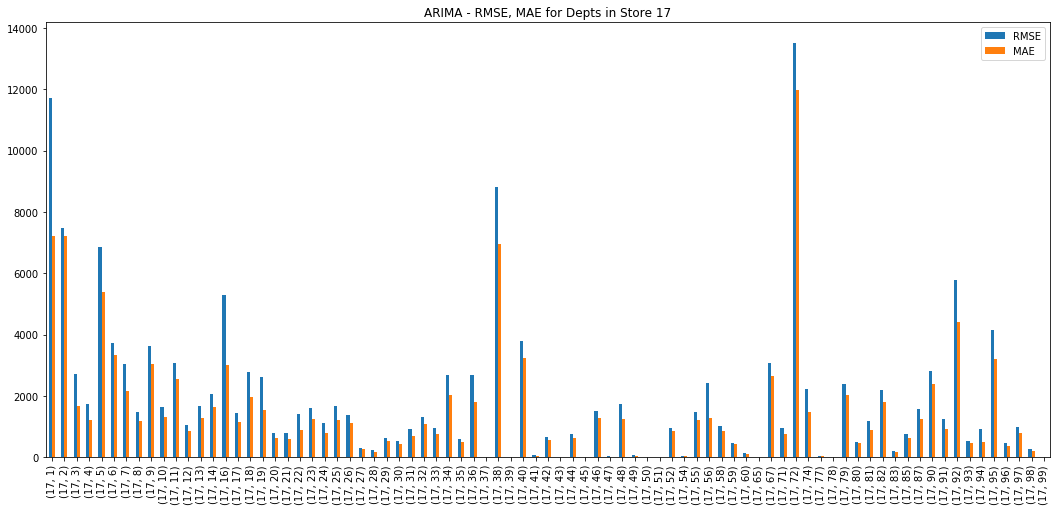

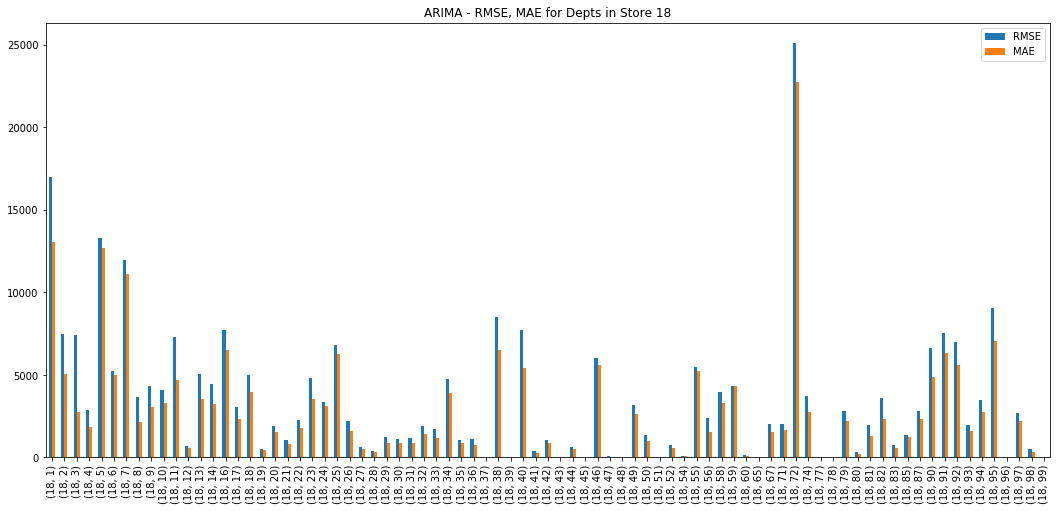

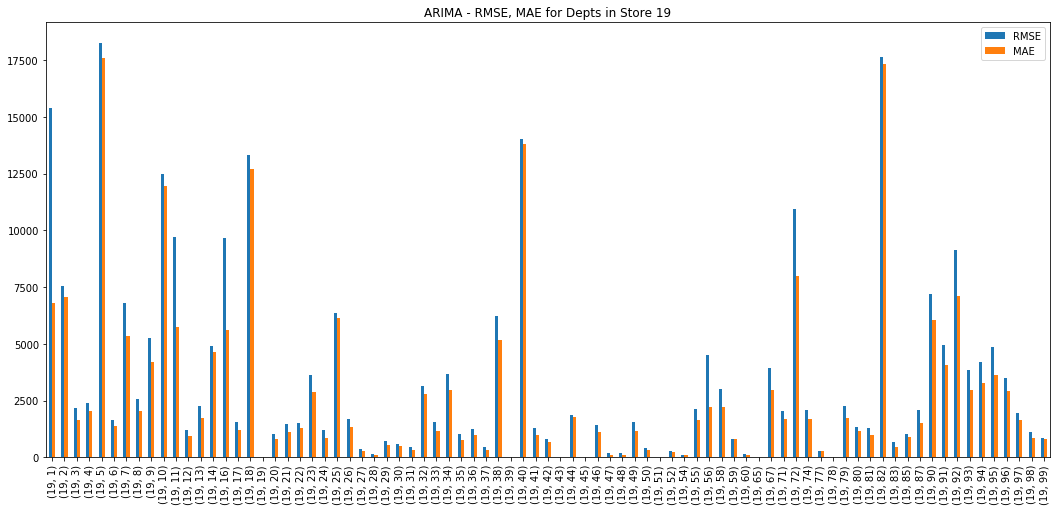

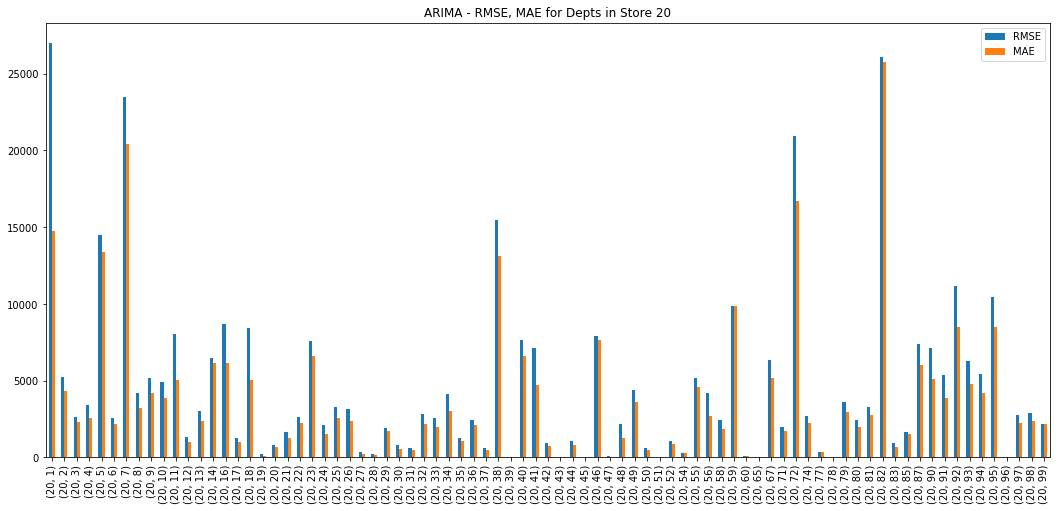

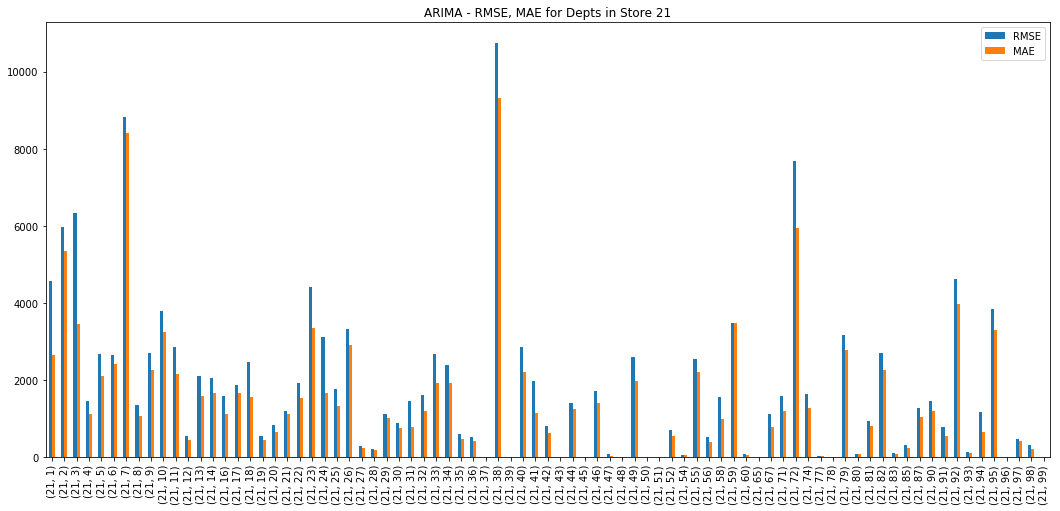

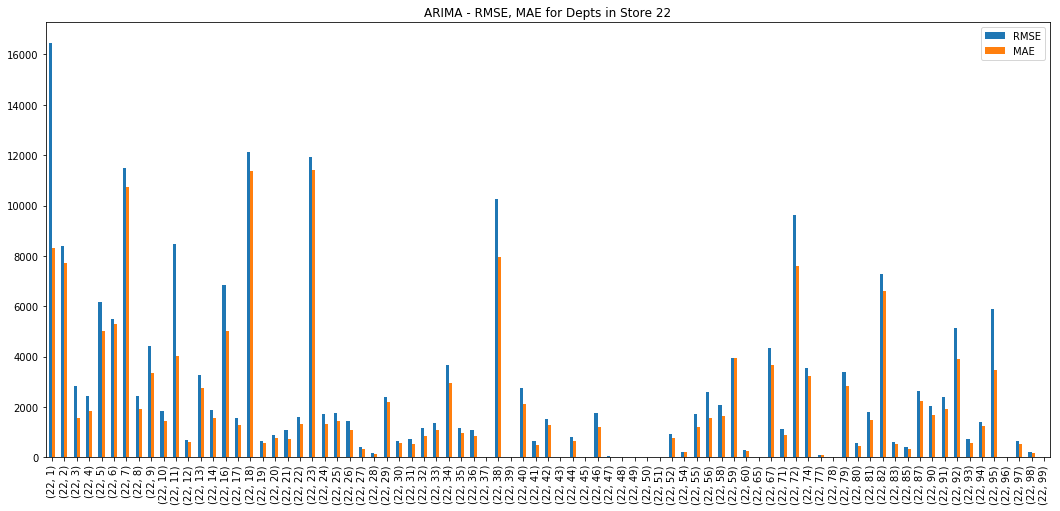

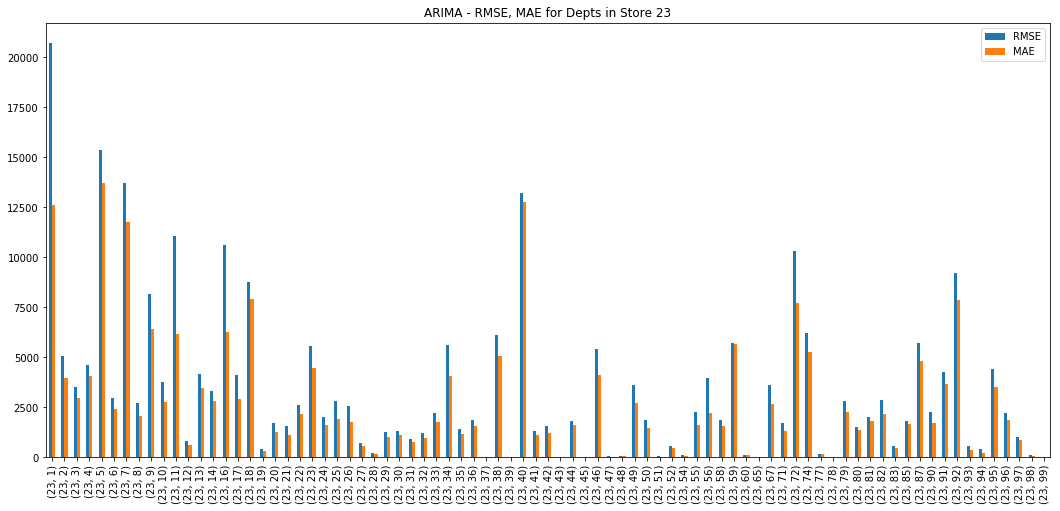

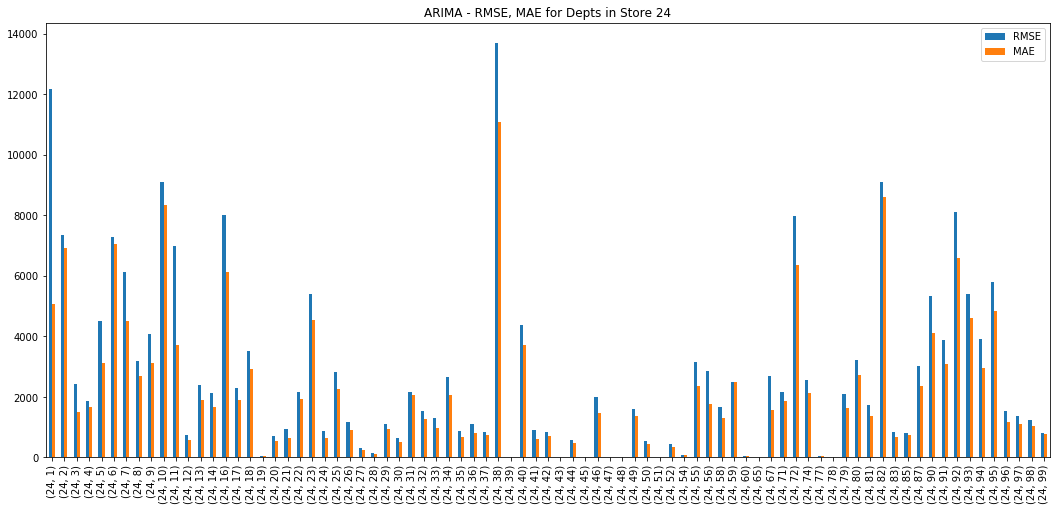

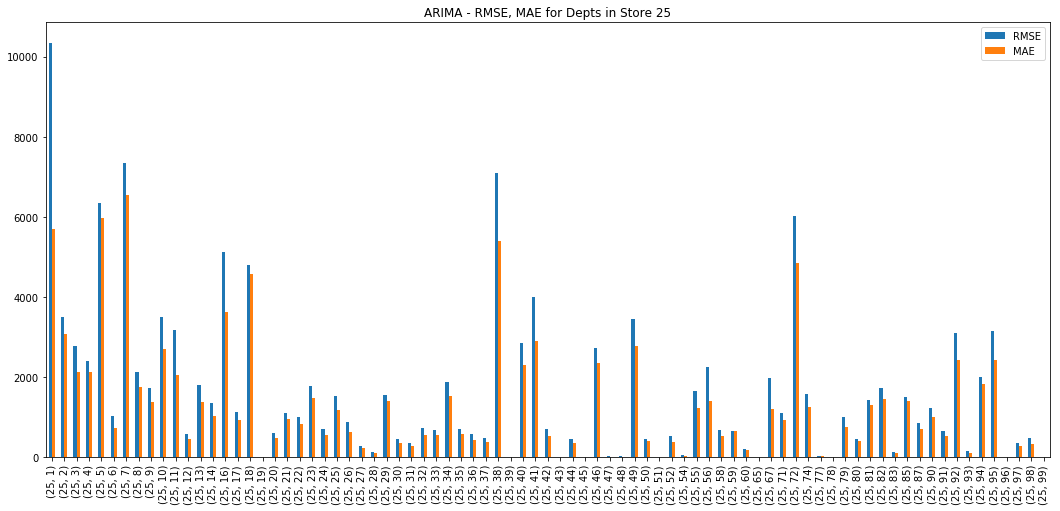

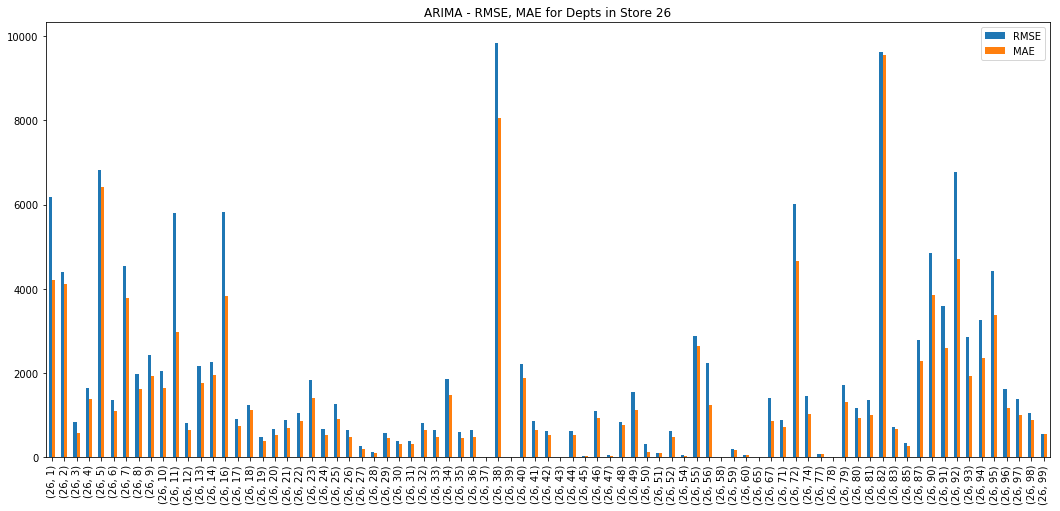

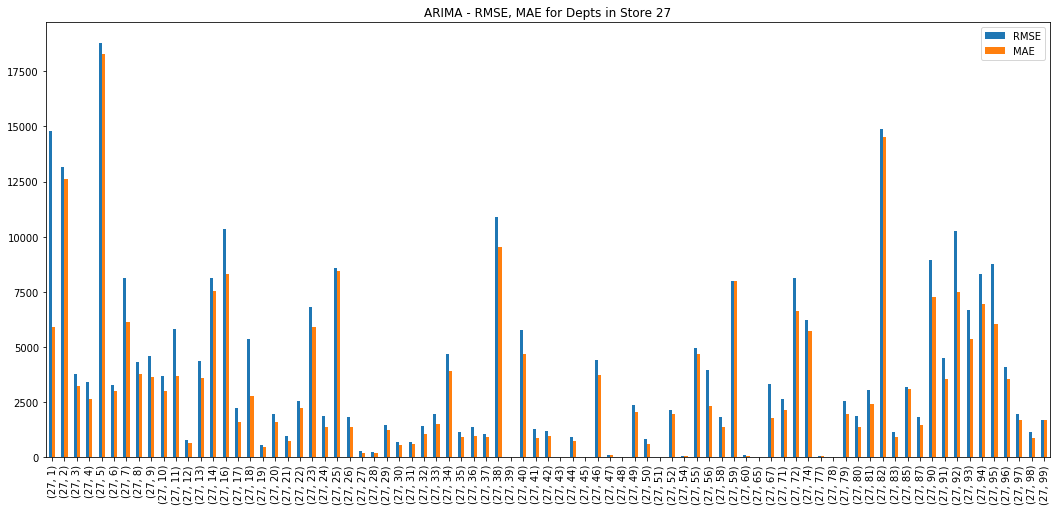

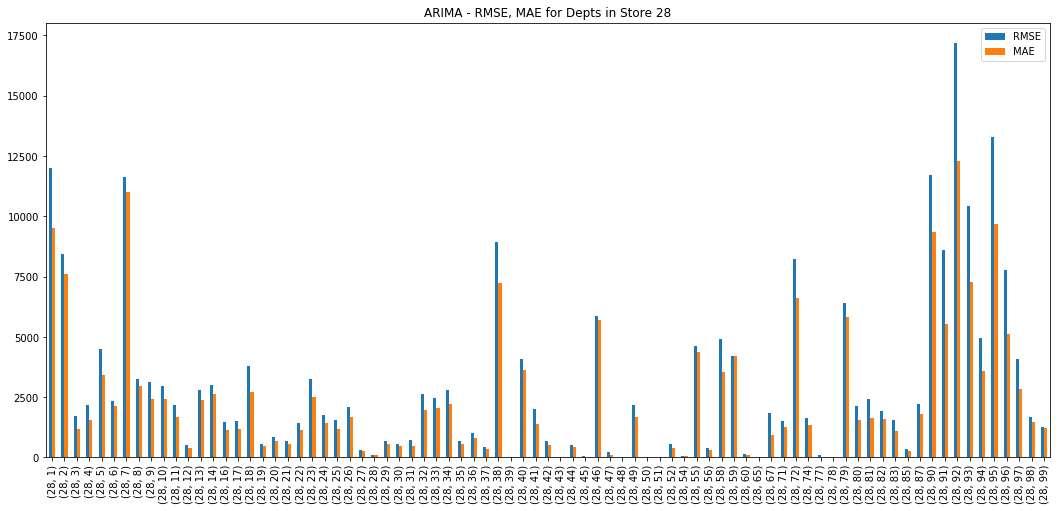

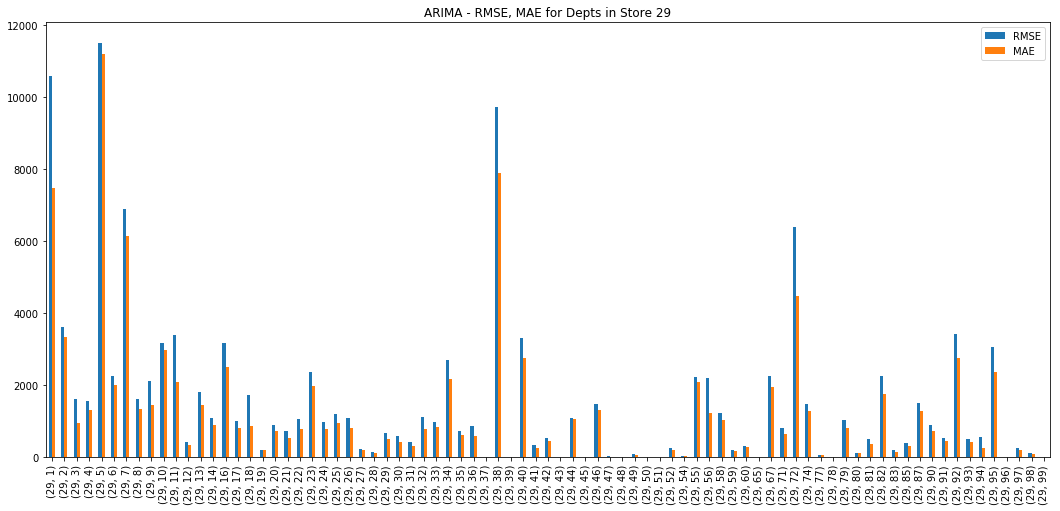

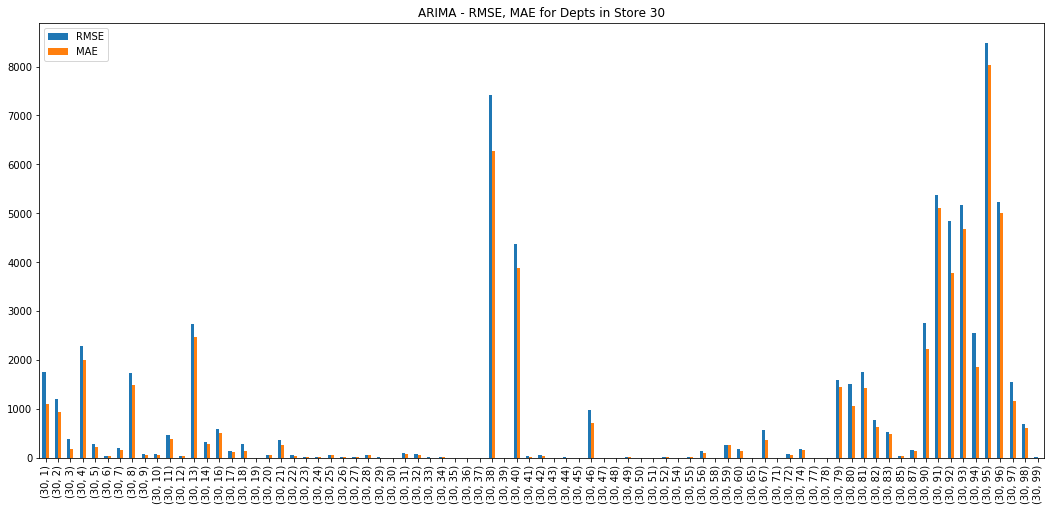

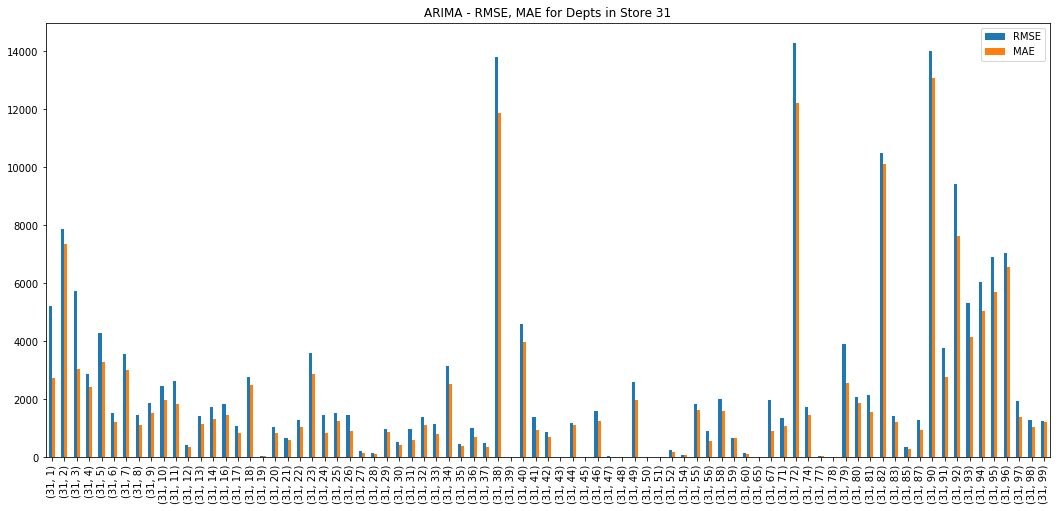

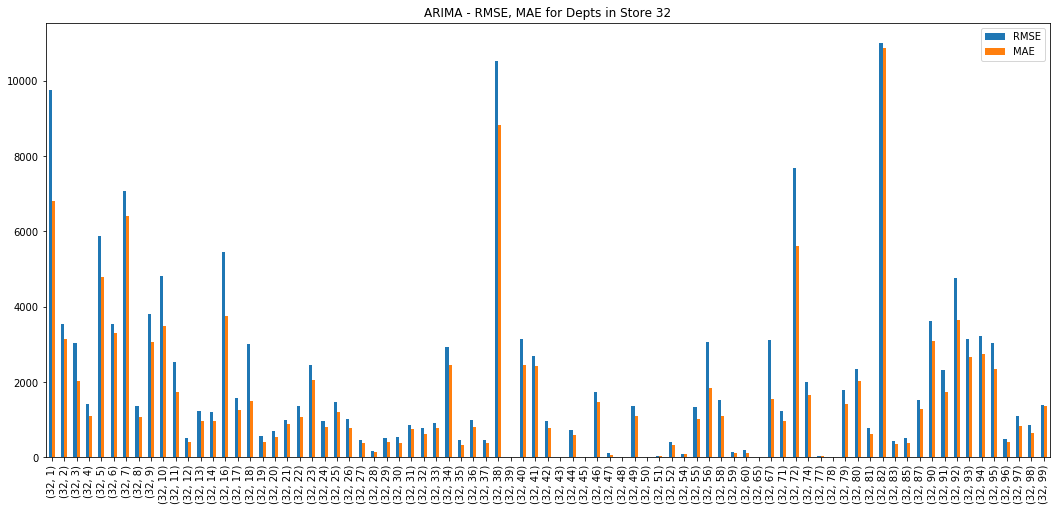

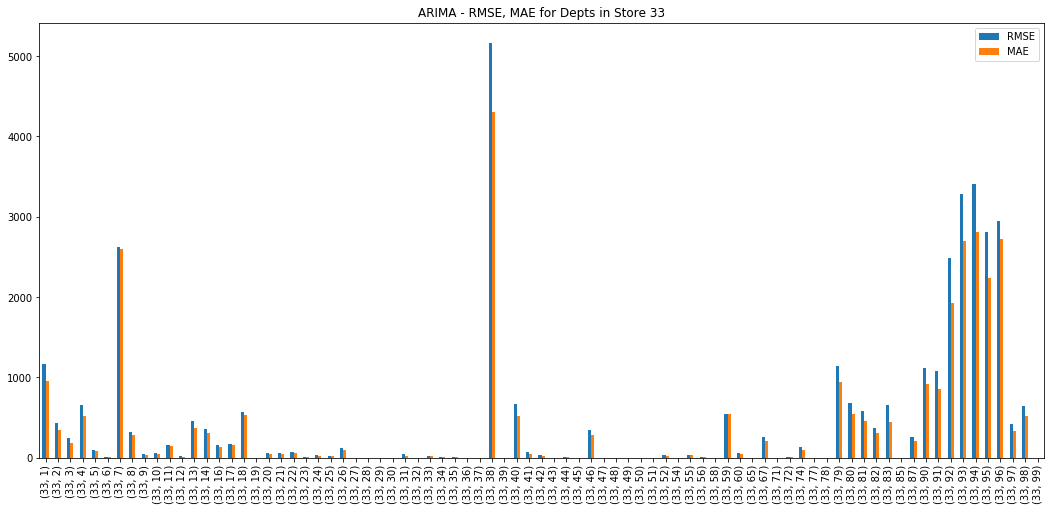

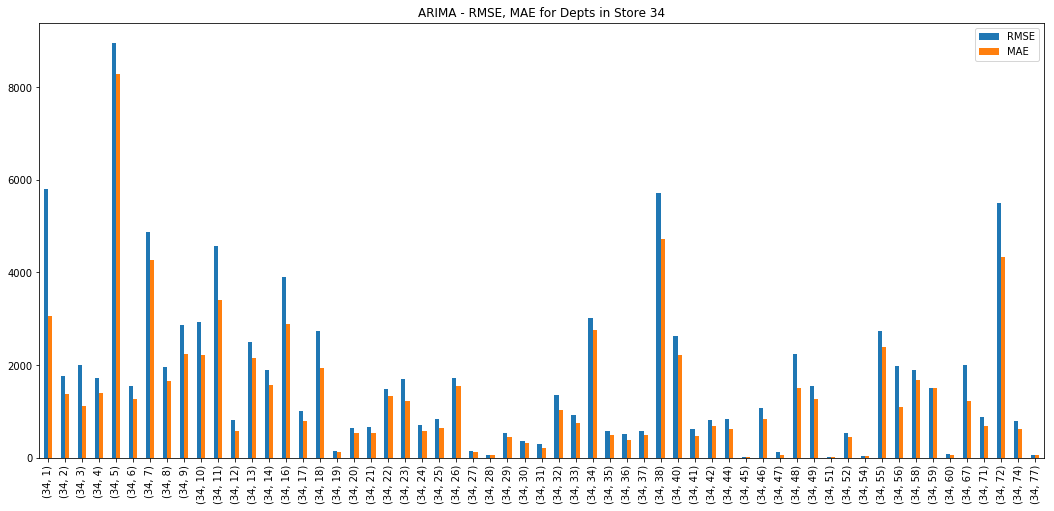

In [44]:
## Plot 
for item in chunks(arima_forecast_results, 81):
    #print(item)
    df = pd.DataFrame(item).T
    ax = df.plot(kind='bar',figsize=(18,8),title='ARIMA - RMSE, MAE for Depts in Store %d' %list(item.keys())[0][0])
    ax.legend(['RMSE', 'MAE']);

In [66]:
prophet_results = pd.read_csv('fbprophet_results.csv')

In [67]:
arima_results = pd.read_csv('arima_results.csv')

In [68]:
prophet_results['Model'] = 'Prophet'
arima_results['Model'] = 'ARIMA'

In [69]:
Results = pd.concat([prophet_results,arima_results])

In [70]:
Results

,Store,Dept,RMSE,MAE,Model
0,1,1,6221.381254,3781.841566,Prophet
1,1,2,3029.452490,2575.510711,Prophet
2,1,3,4048.060789,2313.610929,Prophet
3,1,4,2928.250259,2287.166269,Prophet
4,1,5,5504.912417,4020.525121,Prophet
5,1,6,2074.863189,1466.108774,Prophet
6,1,7,9574.431889,5999.888049,Prophet
7,1,8,3982.486253,3418.751728,Prophet
8,1,9,5252.523373,3477.957469,Prophet
9,1,10,3500.662691,2896.731736,Prophet


In [71]:
Results.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6377 entries, 0 to 2731
Data columns (total 5 columns):
Store    6377 non-null int64
Dept     6377 non-null int64
RMSE     6377 non-null float64
MAE      6377 non-null float64
Model    6377 non-null object
dtypes: float64(2), int64(2), object(1)
memory usage: 298.9+ KB


In [72]:
MAE_ARIMA_Store = Results[(Results['Model']=='ARIMA')].groupby(['Store'])['MAE'].sum()
MAE_Prophet_Store = Results[(Results['Model']=='Prophet')].groupby(['Store'])['MAE'].sum()

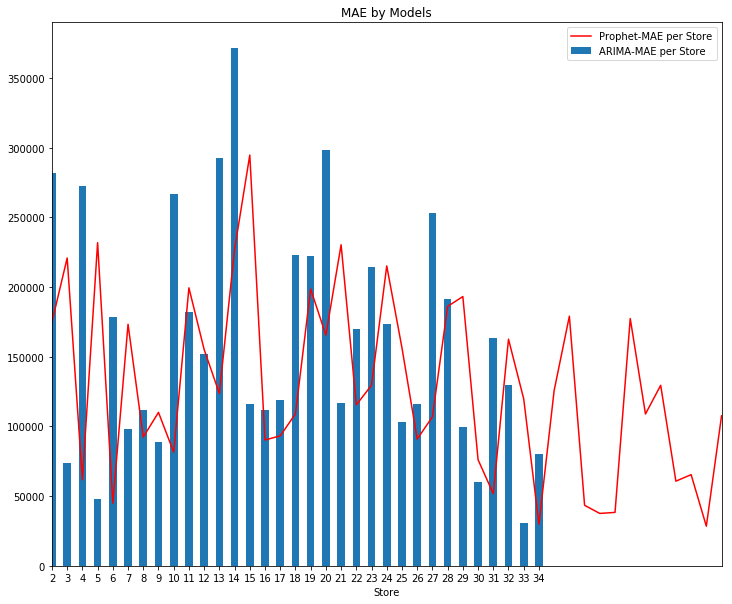

In [73]:
MAE_ARIMA_Store.plot(kind='bar',figsize=(12,10),label='ARIMA-MAE per Store');
MAE_Prophet_Store.plot(kind='line',figsize=(12,10),color='red',label='Prophet-MAE per Store');
plt.title('MAE by Models')
plt.legend(loc='best')

In [74]:
RMSE_ARIMA_Store = Results[(Results['Model']=='ARIMA')].groupby(['Store'])['RMSE'].sum()
RMSE_Prophet_Store = Results[(Results['Model']=='Prophet')].groupby(['Store'])['RMSE'].sum()

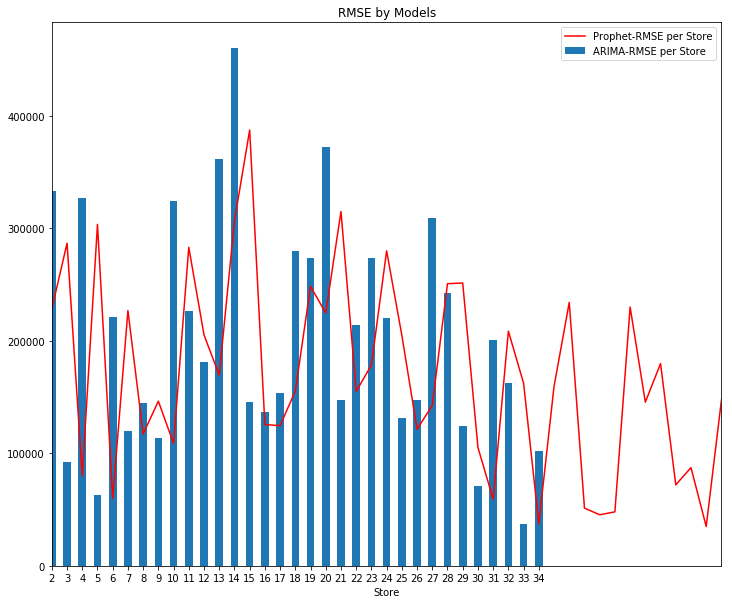

In [75]:
RMSE_ARIMA_Store.plot(kind='bar',figsize=(12,10),label='ARIMA-RMSE per Store');
RMSE_Prophet_Store.plot(kind='line',figsize=(12,10),color='red',label='Prophet-RMSE per Store');
plt.title('RMSE by Models')
plt.legend(loc='best')

In [ ]:
### Function fixed to run the store 34, dept 78 value error. The error was that the bestpdq and best seasonal pdq 
### were None, as the train data has only 1 record.

def forecast_sales_arima(df, store_locations, departments):
    
    pdq_dict = collections.defaultdict(list)    
    result_dict = collections.defaultdict(list)   
    
    
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, d, q))]    
    try:
        for store in store_locations:
            for dept in departments:
                df_str_dept = df[(df['Store']==store) & (df['Dept']==dept)][['Weekly_Sales']]
                daterange = pd.date_range(start=df.index.min().date(),end=df.index.max().date(), freq='W-FRI')             
                missing = sorted(set(daterange)  - set(df_str_dept.index))            
                if(len(missing) >= 1):                
                    df_str_dept = df_str_dept.reindex(daterange, fill_value=0) ## fill missing weekdays with 0
                    y = df_str_dept['Weekly_Sales']                
                else:                
                    y = df_str_dept['Weekly_Sales']
                
                if(all(v == 0 for v in y)):                
                    print("All values in the series are 0 for Store %d, Dept %d" %(store, dept))
                    rmse = 0
                    mae = 0
                else:                                          
                    best_aic = np.inf
                    best_pdq = None
                    best_seasonal_pdq = None
                    tmp_model = None
                    best_mdl = None
                    train_size = int(len(y) * 0.70)
                    y_train, y_test = y[0:train_size], y[train_size:len(y)]
                    
                    for param in pdq:
                        for param_seasonal in seasonal_pdq:
                            try:
                                tmp_mdl = sm.tsa.statespace.SARIMAX(y_train,
                                                order = param,
                                                seasonal_order = param_seasonal,
                                                enforce_stationarity=True,
                                                enforce_invertibility=True)
                                res = tmp_mdl.fit()
                                if res.aic < best_aic:
                                    best_aic = res.aic
                                    best_pdq = param
                                    best_seasonal_pdq = param_seasonal
                                    best_mdl = tmp_mdl
                            except:
                                   # print("Unexpected error:", sys.exc_info()[0])
                                continue
                    
                    print(best_seasonal_pdq)
                    model = sm.tsa.statespace.SARIMAX(y_train, order = best_pdq,seasonal_order = best_seasonal_pdq
                                                  ,enforce_stationarity=True
                                              ,enforce_invertibility=True)
                    result = model.fit()
                    result.summary()
            
            
            ## Out of sample prediction
            ## Predict for train_df and test_df timeframe
                    forecast_out = result.predict(start=pd.to_datetime(y_train.index[0].date()), 
                              end=pd.to_datetime(y_test.index[-1].date()),
                              dynamic=False, full_results=True)
                    
                    forecast_out.head()
                    
            ## Create metrics_df that holds forecasted values for test_df timeframe and original test_df
                    metrics_df = pd.concat((forecast_out[y_test.index[0]:y_test.index[-1]], y_test), axis=1)
                    metrics_df.columns = ['y_hat', 'y_true']            
            
                    mse = mean_squared_error(metrics_df['y_true'], metrics_df['y_hat'])
                    rmse = np.sqrt(mse)
                    mae = mean_absolute_error(metrics_df['y_true'], metrics_df['y_hat'])
            
                result_dict[(store,dept)].append(rmse)
                result_dict[(store,dept)].append(mae)
                
    
    except TypeError: 
        print('Value Error store %d, dept %d' %(store, dept))
    return result_dict    